# **Step 0 - Intitialization**

In [1]:
# libraries
library(tidygeocoder)
library(googledrive)
library(tidycensus)
library(gridExtra)
library(lubridate)
library(tidyverse)
library(geojsonio)
library(ggthemes)
library(RSocrata)
library(viridis)
library(ggplot2)
library(janitor)
library(tigris)
library(knitr)
library(readr)
library(spdep)
library(grid)
library(FNN)
library(sf)

Warning message:
"package 'tidycensus' was built under R version 4.4.2"
Warning message:
"package 'geojsonio' was built under R version 4.4.2"
Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson

Warning message:
"package 'RSocrata' was built under R version 4.4.2"
Loading required package: viridisLite

Warning message:
"package 'tigris' was built under R version 4.4.2"
To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.

Warning message:
"package 'spdep' was built under R version 4.4.2"
Loading required package: spData

Warning message:
"package 'spData' was built under R version 4.4.2"
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sf

Warning message:
"package 'sf' was built under R version 4.4.2"
Linking to GEOS 3.12.2, GDAL 3.9.3, PROJ 9.4.1; s

In [2]:
# ensure that dplyr's filter() function works
conflict_prefer('filter', 'dplyr')

[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::filter over any other package.


In [3]:
# initialize coconut
import coconut

%load_ext coconut

In [4]:
%%coconut
# check python's working directory
import os

f'Working directory: {os.getcwd()}' |> print

Working directory: C:\Users\Jixsoh\python-projects\NOPD


In [5]:
# check R's working directory
getwd() %>% print

[1] "C:/Users/Jixsoh/python-projects/NOPD"


In [6]:
# define R functions
pasteurize <- function(df) {
  # Helper function to clean column names
  clean_column_names <- function(col_name) {
    cleaned <- tolower(col_name)
    cleaned <- gsub("[^a-z0-9_]", "_", cleaned)
    cleaned <- gsub("_+", "_", cleaned)
    cleaned <- gsub("^_|_$", "", cleaned)
    return(cleaned)
  }
  
  # Helper function for title case conversion
  # Now correctly handles vectors of strings
  to_title_case <- function(x) {
    # Ensure we're working with a character vector
    if (!is.character(x)) return(x)
    
    # Apply transformation to each element in the vector
    sapply(x, function(str) {
      # Handle NA values
      if (is.na(str)) return(NA)
      
      # Split into words and capitalize first letter of each
      words <- strsplit(tolower(str), " ")[[1]]
      words <- paste0(toupper(substr(words, 1, 1)),
                      substr(words, 2, nchar(words)))
      # Rejoin words with spaces
      paste(words, collapse = " ")
    })
  }
  
  # Main data cleaning operations
  df %>%
    filter(!if_all(everything(), is.na)) %>%
    distinct() %>%
    rename_with(clean_column_names) %>%
    mutate(across(where(is.character), 
                  ~str_trim(.) %>% 
                    to_title_case))
}

# the [stat.summarize] function provides summary stats on a dataset
stat.summarize <- function(df) {
  numeric_df <- df %>%
    select(where(is.numeric))
  
  # Initialize a list to store results
  summary_list <- list()
  
  # Loop through each numeric column and calculate statistics
  for (col in names(numeric_df)) {
    summary_list[[col]] <- c(
      min = min(numeric_df[[col]], na.rm = TRUE),
      max = max(numeric_df[[col]], na.rm = TRUE),
      median = median(numeric_df[[col]], na.rm = TRUE),
      mean = mean(numeric_df[[col]], na.rm = TRUE),
      sd = round(sd(numeric_df[[col]], na.rm = TRUE), 2),
      n = sum(!is.na(numeric_df[[col]]))
    )
  }
  
  # Combine the results into a data frame and transpose
  result <- as.data.frame(do.call(rbind, summary_list))
  
  # Transpose the result to switch rows and columns
  result <- as.data.frame(t(result))
  
  # Set the column names to the measurements
  colnames(result) <- names(numeric_df)
  
  result %>% 
    kable() %>% 
    return()
}

In [7]:
# define Python functions
from terminaltables import AsciiTable

def table(df):
    table_data = [df.columns.tolist()] + df.values.tolist()
    table = AsciiTable(table_data)
    print(table.table)
    
def table_s(df):
    # Select the first 4 and last 4 columns
    df_selected = df.iloc[:, :4].join(df.iloc[:, -4:])
    
    # Prepare the table data: first row is the column names and the rest is the data
    table_data = [df_selected.columns.tolist()] + df_selected.values.tolist()
    
    # Create and print the table
    table = AsciiTable(table_data)
    print(table.table)

# **Step 1 - Munge spatial files**

In [43]:
# connect to drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import os

# Get the parent directory path
parent_dir = os.path.dirname(os.getcwd())
settings = {
    "client_config_file": os.path.join(parent_dir, "client_secrets.json")
}

# Initialize with settings
gauth = GoogleAuth()
gauth.settings.update(settings)
gauth.LocalWebserverAuth()  # This will open a browser window for authentication

# Create GoogleDrive instance
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=873530399210-09cc6676qplfahvqt21umv4p42pucjkf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [45]:
# find the city council districts file
file_list = drive.ListFile({'q': "title='City_Council_Districts.geojson'"}).GetList()

if file_list:  # If we found the file
    file = file_list[0]  # Get the first matching file
    print(f"Found file: {file['title']} (ID: {file['id']})")
    
    # Check if the file already exists locally
    if not os.path.exists('./data/council-districts.geojson'):
        # Download the file if it doesn't exist locally
        file.GetContentFile('./data/council-districts.geojson')  # Downloads to current directory
        print("File downloaded successfully!")
    else:
        print("File already exists locally.")
else:
    print("Could not find City_Council_Districts.geojson in your Google Drive")

Found file: City_Council_Districts.geojson (ID: 1oJlq6km70DGTiLWEoe7WD8S5IEcSBCnX)
File already exists locally.


In [46]:
# find the neighborhoods file
file_list = drive.ListFile({'q': "title='Neighborhood_Statistical_Areas.geojson'"}).GetList()

if file_list:  # If we found the file
    file = file_list[0]  # Get the first matching file
    print(f"Found file: {file['title']} (ID: {file['id']})")
    
    # Check if the file already exists locally
    if not os.path.exists('./data/neighborhoods.geojson'):
        # Download the file if it doesn't exist locally
        file.GetContentFile('./data/neighborhoods.geojson')  # Downloads to current directory
        print("File downloaded successfully!")
    else:
        print("File already exists locally.")
else:
    print("Could not find Neighborhood_Statistical_Areas.geojson in your Google Drive")

Found file: Neighborhood_Statistical_Areas.geojson (ID: 1WmNbupfiXUlDo_0AySeY8_NllJg2_Wl4)
File already exists locally.


In [103]:
# find the NOPD districts file
file_list = drive.ListFile({'q': "title='NOPD Districts.geojson'"}).GetList()

if file_list:  # If we found the file
    file = file_list[0]  # Get the first matching file
    print(f"Found file: {file['title']} (ID: {file['id']})")
    
    # Check if the file already exists locally
    if not os.path.exists('./data/nopd-districts.geojson'):
        # Download the file if it doesn't exist locally
        file.GetContentFile('./data/nopd-districts.geojson')  # Downloads to current directory
        print("File downloaded successfully!")
    else:
        print("File already exists locally.")
else:
    print("Could not find NOPD Districts.geojson in your Google Drive")

Found file: NOPD Districts.geojson (ID: 1cuEIO1tywM9inAnIYZ-VvSrRodQwNSx6)
File already exists locally.


In [104]:
# find the NOPD reporting districts file
file_list = drive.ListFile({'q': "title='NOPD Reporting Districts.geojson'"}).GetList()

if file_list:  # If we found the file
    file = file_list[0]  # Get the first matching file
    print(f"Found file: {file['title']} (ID: {file['id']})")
    
    # Check if the file already exists locally
    if not os.path.exists('./data/reporting-districts.geojson'):
        # Download the file if it doesn't exist locally
        file.GetContentFile('./data/reporting-districts.geojson')  # Downloads to current directory
        print("File downloaded successfully!")
    else:
        print("File already exists locally.")
else:
    print("Could not find NOPD Reporting Districts.geojson in your Google Drive")

Found file: NOPD Reporting Districts.geojson (ID: 1bDDqON3mrSuDYRkACQBD5lhN5OB2aCHW)
File already exists locally.


In [105]:
# find the NOLA landmass file
file_list = drive.ListFile({'q': "title='Orleans_Parish_-_Landmass.geojson'"}).GetList()

if file_list:  # If we found the file
    file = file_list[0]  # Get the first matching file
    print(f"Found file: {file['title']} (ID: {file['id']})")
    
    # Check if the file already exists locally
    if not os.path.exists('./data/land-mass.geojson'):
        # Download the file if it doesn't exist locally
        file.GetContentFile('./data/land-mass.geojson')  # Downloads to current directory
        print("File downloaded successfully!")
    else:
        print("File already exists locally.")
else:
    print("Could not find Orleans_Parish_-_Landmass.geojson in your Google Drive")

Found file: Orleans_Parish_-_Landmass.geojson (ID: 15EkZWKGjHku3PMmZPB5ASfJCCkOAaa9u)
File already exists locally.


Reading layer `Orleans_Parish_-_Landmass' from data source 
  `B:\Program Files\GitHub\python-projects\NOPD\data\land-mass.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 8 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -90.13996 ymin: 29.86561 xmax: -89.62779 ymax: 30.17481
Geodetic CRS:  WGS 84


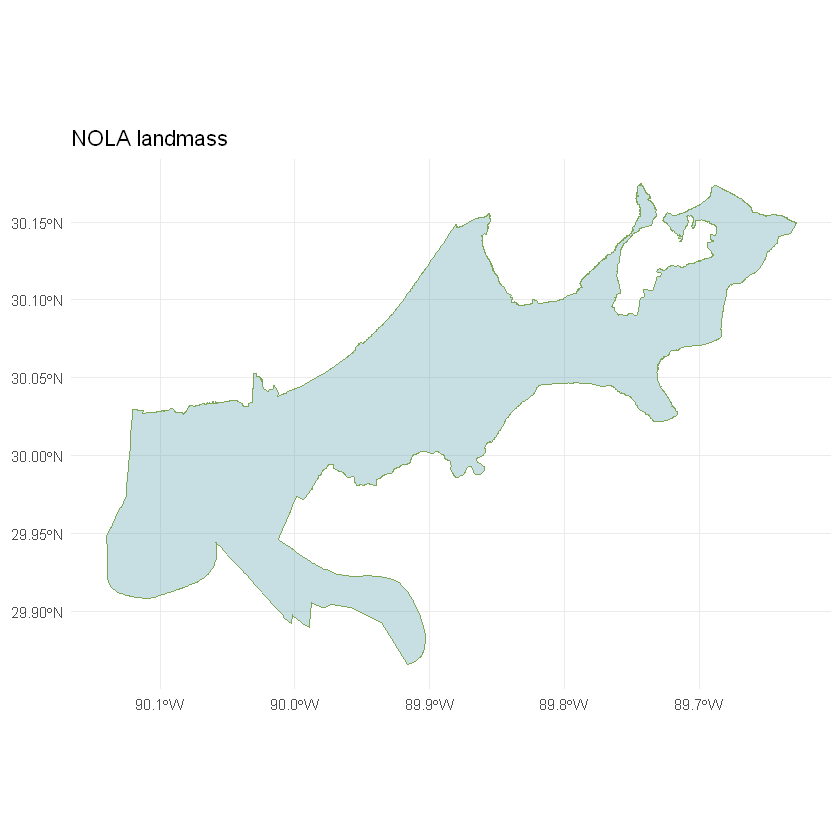

In [8]:
# load in NOLA landmass
l.mass <- 
  st_read('./data/land-mass.geojson') %>% 
  st_transform(crs = 4326)

l.mass %>% 
  ggplot() +
  geom_sf(fill = '#4495a2', color = '#7ca655', alpha = .3) +
  labs(title = 'NOLA landmass') +
  theme_minimal()

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


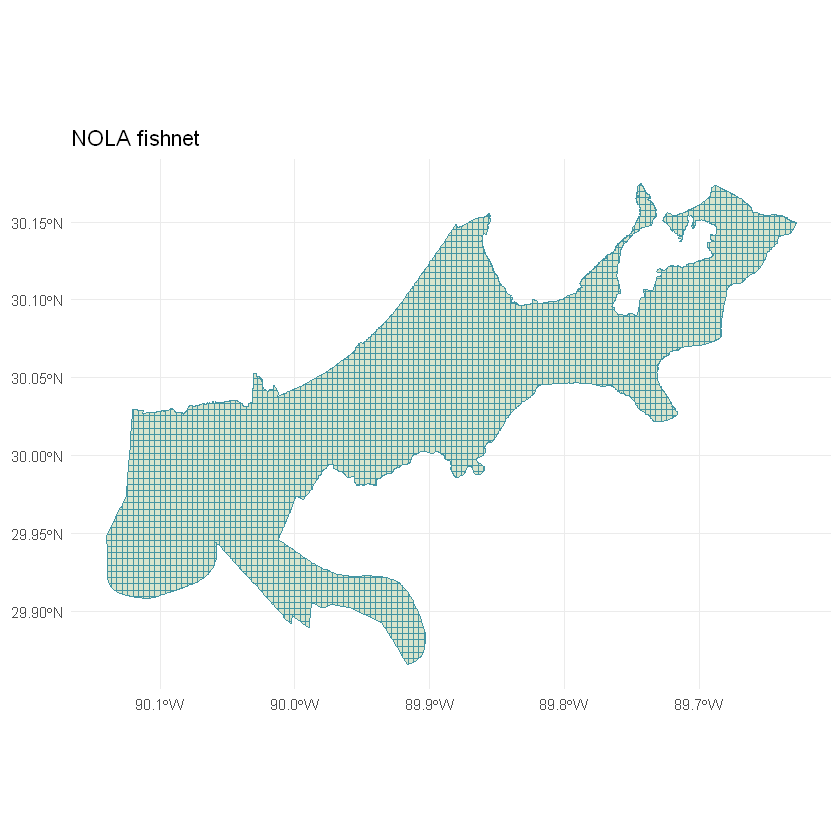

In [9]:
# generate fishnet
f.net <- st_make_grid(l.mass, cellsize = c(0.004, 0.004)) %>% 
  st_sf() %>% 
  mutate(uniqueID = rownames(.)) %>% 
  st_intersection(l.mass)

f.net %>% 
  ggplot() +
  geom_sf(fill = '#7ca655', color = '#4495a2', alpha = .3) +
  labs(title = 'NOLA fishnet') +
  theme_minimal()

In [10]:
neighborhoods <- st_read('./data/neighborhoods.geojson') %>%
    clean_names() %>%
    st_transform(crs = 4326)

nopd_districts <- st_read('./data/nopd-districts.geojson') %>%
    clean_names() %>%
    st_transform(crs = 4326)

Reading layer `Neighborhood_Statistical_Areas' from data source 
  `B:\Program Files\GitHub\python-projects\NOPD\data\neighborhoods.geojson' 
  using driver `GeoJSON'
Simple feature collection with 72 features and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -90.14004 ymin: 29.86561 xmax: -89.62779 ymax: 30.17481
Geodetic CRS:  WGS 84
Reading layer `nopd-districts' from data source 
  `B:\Program Files\GitHub\python-projects\NOPD\data\nopd-districts.geojson' 
  using driver `GeoJSON'
Simple feature collection with 8 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -90.13996 ymin: 29.86478 xmax: -89.62537 ymax: 30.17681
Geodetic CRS:  WGS 84


# **Step 2 - Munge calls for service**

In [15]:
# load in 2023 calls for service (cfs)
path <- './data/cfs-2023.csv'

if(!file.exists(path)) {
  write.csv(read.socrata('https://data.nola.gov/api/odata/v4/pc5d-tvaw'), 
            file = path, 
            row.names = FALSE)
}

# initial clean of cfs
cfs <- read.csv(path) %>%                                   
  pasteurize() %>% 
  na.omit() %>% 
  distinct()

# fix character strings
cfs <- cfs %>%                                                                      
  mutate(type = as.factor(type)) %>% 
  mutate(priority = as.factor(priority)) %>% 
  mutate(selfinitiated = as.factor(selfinitiated)) %>% 
  mutate(disposition = as.factor(disposition)) %>% 
  mutate(dispositiontext = as.factor(dispositiontext)) %>% 
  mutate(selfinitiated = as.factor(selfinitiated))

# extract long and lat from the location var
cfs <- cfs %>% 
  mutate(long.lat = str_extract(location, "\\-?\\d+\\.\\d+ \\-?\\d+\\.\\d+"),
         long.lat = str_replace(long.lat, " ", ",")) %>% 
  separate(long.lat, into = c('x', 'y'), sep = ',') %>% 
  mutate(x = as.numeric(x), y = as.numeric(y)) %>% 
  na.omit()

# extracts long and lat from the location var
cfs <- cfs %>% 
  st_as_sf(coords = c('x', 'y'), crs = 4326, agr = "constant") %>%        
  distinct()

In [16]:
cfs %>% glimpse()

Rows: 130,228
Columns: 22
$ nopd_item       <chr> "A0000323", "A0000623", "A0000723", "A0000923", "A0001…
$ type            <fct> Stfired, Stfired, Stfired, Stfired, Suspp, Stfired, St…
$ typetext        <chr> "Shots Fired", "Shots Fired", "Shots Fired", "Shots Fi…
$ priority        <fct> 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, …
$ initialtype     <chr> "Stfired", "Stfired", "Stfired", "Stfired", "Suspp", "…
$ initialtypetext <chr> "Shots Fired", "Shots Fired", "Shots Fired", "Shots Fi…
$ initialpriority <chr> "2", "2", "2", "2", "1", "2", "2", "2", "2", "2", "2",…
$ mapx            <int> 3696157, 3698194, 3679649, 3676773, 3702360, 3681601, …
$ mapy            <int> 532824, 533068, 533305, 536990, 520618, 552052, 534643…
$ timecreate      <chr> "2023-01-01 00:01:27", "2023-01-01 00:03:09", "2023-01…
$ timedispatch    <chr> "2023-01-01 10:36:08", "2023-01-01 10:27:30", "2023-01…
$ timearrive      <chr> "2023-01-01 10:38:51", "2023-01-01 10:29:39", "2023-01…
$ timeclosed  

# **Step 3 - Classify call types**

In [123]:
# import pre-defined charge category schema
cats <- read.csv('./data/charge-categories.csv') %>% 
  pasteurize() %>% 
  select(charge, category) %>% 
  filter(category %in% c('Violent',
                         'Property',
                         'Sex Offense',
                         'Weapons',
                         'Attachments',
                         'Traffic',
                         'Drugs'))

cats %>% glimpse()

Rows: 1,139
Columns: 2
$ charge   <chr> "Assault On A School Teacher", "Theft", "Attempted Second Deg…
$ category <chr> "Violent", "Property", "Violent", "Violent", "Violent", "Viol…


In [160]:
%get cats --from R

%%coconut

# bring charge categories into python
cats |> head(15) |> table

+--------------------------------------------------+-------------+
| charge                                           | category    |
+--------------------------------------------------+-------------+
| Assault On A School Teacher                      | Violent     |
| Theft                                            | Property    |
| Attempted Second Degree Murder                   | Violent     |
| Prin 1st Degree Murder                           | Violent     |
| Principle To Second Degree Murder                | Violent     |
| Principal To Aggravated Battery                  | Violent     |
| Principal To 2nd Degree Battery                  | Violent     |
| Principal To Simple Battery                      | Violent     |
| Principal To Aggravated Assault                  | Violent     |
| Principal To Aggravated Assault On Peace Officer | Violent     |
| Principal To Aggravated Assault With Firearm     | Violent     |
| Principal To Aggravated Domestic Abuse           | Violent  

In [167]:
%%coconut

# bring 2023 cfs into python
import pandas as pd
from siuba import *

cfs = pd.read_csv('./data/cfs-2023.csv') |> pd.DataFrame

# preview cfs data
cfs |> head(15) |> table_s

+-----------+---------+-------------------------+----------+-------------------------------+---------+----------------+----------------------------------+
| nopd_item | type_   | typetext                | priority | block_address                 | zip     | policedistrict | location                         |
+-----------+---------+-------------------------+----------+-------------------------------+---------+----------------+----------------------------------+
| A0000123  | STFIRED | SHOTS FIRED             | 1        | N Galvez St & Poland Av       | 70117.0 | 5              | POINT (-90.02946537 29.97525615) |
| A0000223  | MISC    | MISCELLANEOUS COMPLAINT | 1        | Julia St & Commerce St        | 70130.0 | 8              | POINT (-90.06666469 29.94479157) |
| A0000323  | STFIRED | SHOTS FIRED             | 1        | 007XX Blk Lizardi St          | 70117.0 | 5              | POINT (-90.02173891 29.95862992) |
| A0000423  | MISC    | MISCELLANEOUS COMPLAINT | 1        | 004XX Bou

In [170]:
%%coconut

import spacy

# Load spaCy model (import with: !python -m spacy download en_core_web_lg)
nlp = spacy.load('en_core_web_lg')

# Define a function to clean text
def preprocess_text(text):
    doc = nlp(str(text).lower().strip())
    clean_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(clean_tokens)

# Apply text preprocessing on cfs
cfs_distinct = cfs['typetext'].drop_duplicates().reset_index(drop=True)
cfs_distinct = pd.DataFrame({'typetext': cfs_distinct})
cfs_distinct['cleaned_text'] = cfs_distinct['typetext'].apply(preprocess_text)

# Apply text preprocessing on cats
cats['cleaned_text'] = cats['charge'].apply(preprocess_text)
cats = cats |> select(_.charge, 
                      _.cleaned_text, 
                      _.category)

# Save cleaned cfs and cats
cfs_distinct.to_csv('./data/cfs-cleaned.csv', index = False)
cats.to_csv('./data/cats-cleaned.csv', index = False)

In [174]:
%%coconut

# Re-load cleaned cfs and cats
cfs_cleaned = pd.read_csv('./data/cfs-cleaned.csv')
cats_cleaned = pd.read_csv('./data/cats-cleaned.csv')

# Preview cleaned cfs and cats files
'cfs:' |> print
cfs_cleaned |> head(15) |> table

'cats:' |> print
cats_cleaned |> head(15) |> table

cfs:
+----------------------------------------+-----------------------------------+
| typetext                               | cleaned_text                      |
+----------------------------------------+-----------------------------------+
| SHOTS FIRED                            | shot fire                         |
| MISCELLANEOUS COMPLAINT                | miscellaneous complaint           |
| AREA CHECK                             | area check                        |
| ILLEGAL FIREWORKS                      | illegal firework                  |
| SUSPICIOUS PERSON                      | suspicious person                 |
| SIMPLE ASSAULT                         | simple assault                    |
| ALARM: RESIDENTIAL - BURGLARY          | alarm residential burglary        |
| DESTRUCTION OF PROPERTY                | destruction property              |
| ACCIDENT - HIT & RUN                   | accident hit run                  |
| ASSAULT W/WEAPON - SHOOTING (PD)       | assa

In [177]:
# initialize classification model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create TF-IDF vectors
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(cats_cleaned['cleaned_text'])
y_train = cats_cleaned['category']

# Train model
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

# Transform CFS data
X_cfs = vectorizer.transform(cfs_cleaned['cleaned_text'])

# Predict categories
predictions = model.predict(X_cfs)

# Add predictions to CFS data
cfs_cleaned['predicted_category'] = predictions

# Add prediction probabilities
prediction_probs = model.predict_proba(X_cfs)
cfs_cleaned['confidence'] = prediction_probs.max(axis = 1)

In [181]:
%%coconut

# Split cats data
X = vectorizer.fit_transform(cats_cleaned['cleaned_text'])
y = cats_cleaned['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Train and evaluate
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print performance metrics
classification_report(y_test, y_pred, zero_division = 1) |> print

              precision    recall  f1-score   support

 Attachments       1.00      0.00      0.00         1
       Drugs       0.86      1.00      0.93        76
    Property       0.97      0.94      0.95        62
 Sex Offense       1.00      0.60      0.75        10
     Traffic       1.00      0.87      0.93        15
     Violent       0.96      1.00      0.98        54
     Weapons       1.00      0.50      0.67        10

    accuracy                           0.93       228
   macro avg       0.97      0.70      0.74       228
weighted avg       0.94      0.93      0.92       228



In [186]:
%%coconut

from siuba import arrange, \filter, _

# predict CFS categories
X_cfs = vectorizer.transform(cfs_cleaned['cleaned_text'])
cfs_cleaned['predicted_category'] = model.predict(X_cfs)
cfs_cleaned['confidence'] = model.predict_proba(X_cfs).max(axis=1)

# display sample of lowest confidence predictions
cfs_cleaned \
    |> select('cleaned_text', 'predicted_category', 'confidence') \
    |> filter(_.confidence <= 0.50) \
    |> arrange('confidence') \
    |> _.round(2) \
    |> head(15) \
    |> table

+-----------------------------------+--------------------+------------+
| cleaned_text                      | predicted_category | confidence |
+-----------------------------------+--------------------+------------+
| accident injury pd veh            | Drugs              | 0.25       |
| hit run injury                    | Property           | 0.25       |
| test event police                 | Violent            | 0.25       |
| reclass fatal hit run   acc       | Drugs              | 0.26       |
| simple rape                       | Property           | 0.26       |
| suspicious person                 | Drugs              | 0.26       |
| critical miss person              | Drugs              | 0.26       |
| emotionally disturbed person      | Drugs              | 0.26       |
| business burglary                 | Violent            | 0.26       |
| drunk public                      | Drugs              | 0.26       |
| mutual aid law enforcement agency | Drugs              | 0.27 

**Fine-tune classification model**

In [239]:
%%coconut

# 0-a. define new category mappings
category_mapping = {
  
    # Public Order
    'drunk': 'Public Order',
    'disorderly': 'Public Order',
    'loud': 'Public Order',
    'suspicious': 'Public Order',
    'silent': 'Public Order',
    'alarm': 'Public Order',
    'flood': 'Public Order',
    'complaint': 'Public Order',
    'protest': 'Public Order',
    'disturbance': 'Public Order',
    'firework': 'Public Order',
    'loiter': 'Public Order',
    'resource': 'Public Order',
    'solicitor': 'Public Order',
    'curfew violation': 'Public Order',
    'truancy': 'Public Order',
    'quality': 'Public Order',
    'area check': 'Public Order',
    'residence check': 'Public Order',
    'fight': 'Public Order',
    'civil dispute': 'Public Order',
    'patrol': 'Public Order',
    'homeless': 'Public Order',
    'walk': 'Public Order',
    'business check': 'Public Order',
    'area check': 'Public Order',
    'public service': 'Public Order',
    'barricade': 'Public Order',
    'open door': 'Public Order',
    'boat': 'Public Order',
    
    # Other
    'investigation': 'Other',
    'escape': 'Other',
    'test': 'Other',
    'mutual': 'Other',
    'miss person': 'Other',
    'info': 'Other',
    'threat harassment': 'Other',
    'telephone harassment': 'Other',
    'fire dept': 'Other',
    'assistance': 'Other',
    'miss juvenile': 'Other',
    'miss adult': 'Other',
    
    # Medical
    'medical': 'Medical', 
    'cpr': 'Medical',
    'c.p.r': 'Medical',
    'doa': 'Medical',
    'mental': 'Medical',
    'suicide': 'Medical',
    'disturbed': 'Medical',
    'death': 'Medical',
    'ems': 'Medical',
    'overdose': 'Medical',
    
    # Traffic
    'accident': 'Traffic',
    'hit run': 'Traffic',
    'disabled': 'Traffic',
    'parking': 'Traffic',
    'hazard': 'Traffic',
    'parade': 'Traffic',
    'truck': 'Traffic',
    'school crossing': 'Traffic',
    
    # Violent
    'stab': 'Violent',
    'weapon': 'Violent',
    'assault': 'Violent',
    'burglary': 'Violent',
    'bomb threat': 'Violent',
    'homicide': 'Violent',
    'shooting': 'Violent',
    
    # Property
    'eviction': 'Property',
    'trespass': 'Property',
    'shoplift': 'Property',
    'pickpocket': 'Property',
    
    # Sex Offense
    'sexual': 'Sex Offense',
    'sex offense': 'Sex Offense',
    'rape': 'Sex Offense',
    'obscenity': 'Sex Offense',
    'voyeurism': 'Sex Offense',
    
    # Attachments
    'attachment': 'Attachments',
    'warr': 'Attachments',
    
    # Weapons
    'shot fire': 'Weapons',
    'firearm': 'Weapons'
}

# 0-b. define a function to update categories in training data
def map_category(text):
    # first check if it's already in our training categories
    if text in cats_preproc['cleaned_text'].values:
        return cats_preproc[cats_preproc['cleaned_text'] == text]['category'].iloc[0]
    # then check our custom mappings
    for key, value in category_mapping.items():
        if key in text.lower():
            return value
    return 'Other'

# 0-c. define a function to go through custom mappings before attempting classification
def classify_call(text):
    # first try direct mapping
    for key, value in category_mapping.items():
        if key in text.lower():
            return value, 1.0
    # if no mapping, use ML prediction
    X = vectorizer.transform([text])
    pred = model.predict(X)[0]
    conf = model.predict_proba(X).max()
    return pred if conf >= 0.3 else 'Needs Review', conf

# 1. train model on cats data
X = vectorizer.fit_transform(cats_cleaned['cleaned_text'])
y = cats_cleaned['category']  # Use original categories for training
model = LogisticRegression(max_iter = 1000)
model.fit(X, y)

# 2. apply classification
cfs_cleaned[['predicted_category', 'confidence']] = pd.DataFrame(
    [classify_call(text) for text in cfs_cleaned['cleaned_text']], 
    index = cfs_cleaned.index
)

# 3. re-classify 'Needs review' cases as 'Other'
cfs_cleaned = cfs_cleaned \
    |> mutate(predicted_category = _.predicted_category.replace('Needs Review', 'Other'))

# 4. save the classified cfs file
cfs_cleaned.to_csv('./data/cfs-classified.csv', index = False)

# 5. preview charge category counts
cfs_cleaned \
    |> select('predicted_category') \
    |> _.value_counts() \
    |> _.reset_index() \
    |> pd.DataFrame \
    |> table

+--------------------+-------+
| predicted_category | count |
+--------------------+-------+
| Traffic            | 57    |
| Public Order       | 52    |
| Violent            | 50    |
| Property           | 47    |
| Other              | 41    |
| Medical            | 16    |
| Attachments        | 8     |
| Sex Offense        | 7     |
| Drugs              | 2     |
| Weapons            | 2     |
+--------------------+-------+


In [228]:
%%coconut

# preview the lowest confidence call types
cfs_cleaned \
    |> select(~_.typetext) \
    |> arrange('confidence') \
    |> _.round(2) \
    |> head(15) \
    |> table

+-----------------------------+--------------------+------------+
| cleaned_text                | predicted_category | confidence |
+-----------------------------+--------------------+------------+
| underage drinking violation | Other              | 0.29       |
| incident request agency     | Other              | 0.3        |
| fire                        | Other              | 0.3        |
| abduction                   | Other              | 0.3        |
| court                       | Other              | 0.3        |
| unknown sit help            | Other              | 0.3        |
| urgent request pd           | Other              | 0.3        |
| stalk incident              | Other              | 0.3        |
| prisoner transport          | Other              | 0.3        |
| lock pd                     | Other              | 0.3        |
| prowler                     | Other              | 0.3        |
| stake                       | Other              | 0.3        |
| cruelty 

In [237]:
%%coconut

from siuba import \filter

# preview violent call types
cfs_cleaned \
    |> select(~_.typetext) \
    |> filter(_.predicted_category == 'Violent') \
    |> _.round(2) \
    |> head(15) \
    |> arrange(-_.confidence) \
    |> table

+------------------------------------------+--------------------+------------+
| cleaned_text                             | predicted_category | confidence |
+------------------------------------------+--------------------+------------+
| simple assault                           | Violent            | 1.0        |
| assault w weapon shooting pd             | Violent            | 1.0        |
| weapon brandish conceal                  | Violent            | 1.0        |
| burglary vehicle                         | Violent            | 1.0        |
| sexual assault                           | Violent            | 1.0        |
| robbery w weapon                         | Violent            | 1.0        |
| assault w weapon pd                      | Violent            | 1.0        |
| assault w weapon stab pd                 | Violent            | 1.0        |
| commercial burglary                      | Violent            | 1.0        |
| residental burglary occupy time incident | Violent

# **Step 4 - Join CFS with the fishnet**

In [25]:
# bring classified cfs dataset back into R
cfs_class <- read.csv('./data/cfs-classified.csv')

# join on the original cfs dataset
cfs_final <- cfs %>% 
  mutate(typetext = str_to_lower(typetext)) %>% 
  left_join(cfs_class %>% 
              mutate(typetext = str_to_lower(typetext)) %>% 
              select(typetext, cleaned_text, predicted_category), 
            by = 'typetext') %>% 
  select(nopd_item, 
         type, 
         typetext, 
         cleaned_text,
         predicted_category, 
         everything())

# save the final cfs
cfs_final %>% saveRDS('./data/cfs-final.rds')

In [12]:
# load in the final cfs file
cfs_final <- readRDS('./data/cfs-final.rds')

In [19]:
cfs_final %>% 
  select(nopd_item, 
         typetext,
         cleaned_text,
         predicted_category) %>% 
  head(15) %>%
  kable()



|nopd_item |typetext                         |cleaned_text                 |predicted_category |geometry                   |
|:---------|:--------------------------------|:----------------------------|:------------------|:--------------------------|
|A0000323  |shots fired                      |shot fire                    |Weapons            |POINT (-90.02174 29.95863) |
|A0000623  |shots fired                      |shot fire                    |Weapons            |POINT (-90.0153 29.95924)  |
|A0000723  |shots fired                      |shot fire                    |Weapons            |POINT (-90.07385 29.96046) |
|A0000923  |shots fired                      |shot fire                    |Weapons            |POINT (-90.0828 29.97068)  |
|A0001323  |suspicious person                |suspicious person            |Public Order       |POINT (-90.0026 29.92487)  |
|A0002023  |shots fired                      |shot fire                    |Weapons            |POINT (-90.06703 30.01195) 

In [110]:
# what proportion of calls do each call type comrpise?
cfs_summary <- cfs_final %>% 
    st_drop_geometry() %>%
    group_by(predicted_category) %>%
    summarize(count = n()) %>%
    arrange(desc(count))

cfs_summary <- cfs_summary %>%
    mutate(percent = count / sum(count)) %>%
    mutate(across(where(is.numeric), round, 2))

kable(cfs_summary)



|predicted_category | count| percent|
|:------------------|-----:|-------:|
|Public Order       | 56710|    0.44|
|Violent            | 22890|    0.18|
|Traffic            | 18556|    0.14|
|Property           | 16600|    0.13|
|Other              |  7044|    0.05|
|Medical            |  4013|    0.03|
|Weapons            |  2571|    0.02|
|Sex Offense        |   953|    0.01|
|Attachments        |   458|    0.00|
|Drugs              |   433|    0.00|

In [113]:
cfs_final %>% 
    filter(predicted_category == 'Violent') %>%
    st_drop_geometry() %>%
    group_by(typetext) %>%
    summarize(count = n()) %>%
    arrange(desc(count)) %>%
    head(15) %>%
    kable()



|typetext                                               | count|
|:------------------------------------------------------|-----:|
|domestic dispute                                       |  7465|
|domestic violence                                      |  3895|
|burglary from vehicle                                  |  3058|
|simple assault                                         |  2809|
|residental burglary (not occupied at time of incident) |  1320|
|assault w/weapon (pd)                                  |  1023|
|commercial burglary                                    |   707|
|weapon brandish/conceal                                |   704|
|robbery w/weapon                                       |   330|
|robbery                                                |   308|
|abuse/negliect                                         |   245|
|assault w/weapon - shooting (pd)                       |   231|
|shooting (pd)                                          |   197|
|carjacking: robbery   

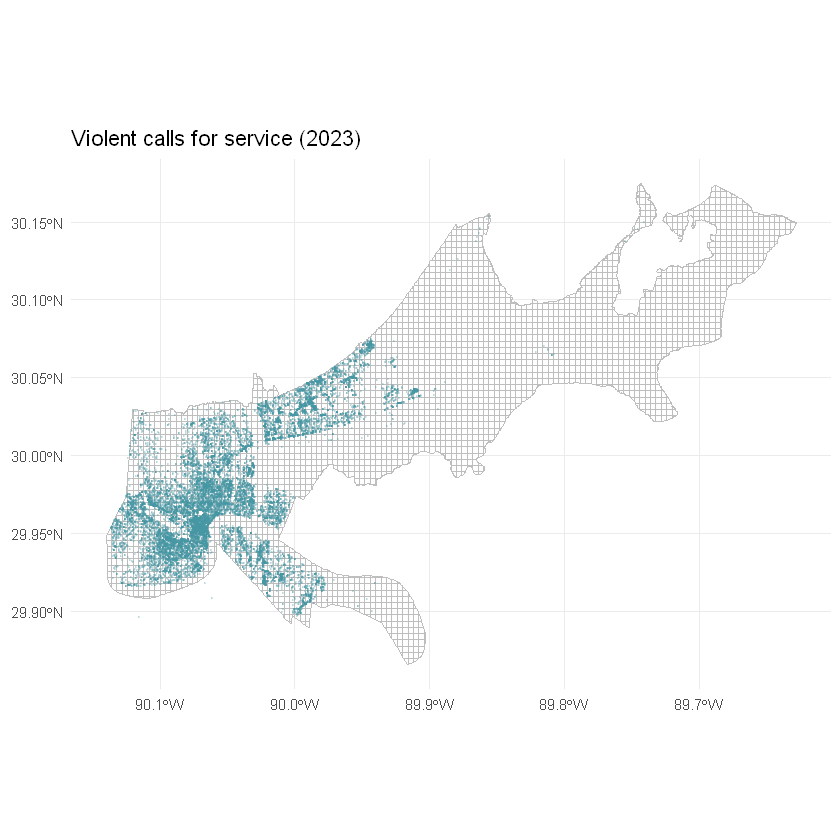

In [13]:
# take a first look at how violent calls look on the fishnet
violent <- cfs_final %>% 
  filter(predicted_category == 'Violent')

# test overlap
violent_map <- ggplot() +
    geom_sf(data = f.net, fill = 'transparent', color = 'grey', alpha = .8) +
    geom_sf(data = violent, color = '#4495a2', size = .3, alpha = .2) +
    labs(title = 'Violent calls for service (2023)') +
    theme_minimal()

violent_map %>% print

ggsave('./data/violent-map.png', 
       plot = violent_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

In [14]:
# clean the fishnet (f.net)
f.net_valid <- st_make_valid(f.net)
violent <- st_make_valid(violent)

# perform a spatial join between assault (points) and f.net (polygons)
multi_net <- st_join(violent, f.net_valid, left = T) %>% 
  filter(!is.na(uniqueID))

# generate the crime net
violent_net <- multi_net %>% 
  group_by(uniqueID) %>% 
  summarize(counter = n()) %>%
  mutate(counter = replace_na(counter, 0))  

# Perform a spatial join between assault (points) and f.net (polygons)
violent_net <- violent %>%
  select() %>% 
  mutate(counter = 1) %>% 
  aggregate(., f.net_valid, sum) %>%
  mutate(counter = replace_na(counter, 0),
         uniqueID = rownames(.),    
         cvID = sample(nrow(f.net) %/% 24, 
                       size = nrow(f.net), 
                       replace = TRUE)
         ) 

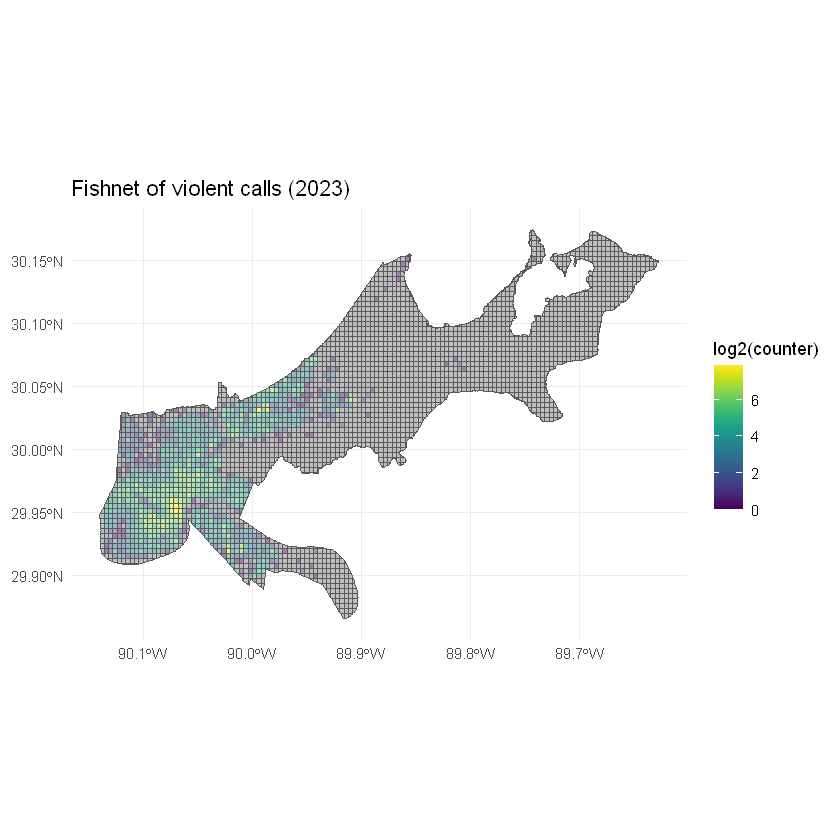

In [15]:
# let's look at an initial map!
violent_map <- violent_net %>%
    ggplot(aes(fill = log2(counter))) +
    geom_sf(size = 0.2, alpha = 0.5) +
    scale_fill_viridis() +
    theme_minimal() + 
    labs(title = 'Fishnet of violent calls (2023)')

violent_map %>% print

ggsave('./data/violent-fishnet.png', 
       plot = violent_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

# **Step 5 - Munge risk factors**

**Bring in code violations**

In [63]:
# find the code violations file
file_list = drive.ListFile({'q': "title='Code_Enforcement_All_Violations.csv'"}).GetList()

if file_list:  # If we found the file
    file = file_list[0]  # Get the first matching file
    print(f"Found file: {file['title']} (ID: {file['id']})")
    
    # Check if the file already exists locally
    if not os.path.exists('./data/code-violations.csv'):
        # Download the file if it doesn't exist locally
        file.GetContentFile('./data/code-violations.csv')  # Downloads to current directory
        print("File downloaded successfully!")
    else:
        print("File already exists locally.")
else:
    print("Could not find Code_Enforcement_All_Violations.csv in your Google Drive")

Found file: Code_Enforcement_All_Violations.csv (ID: 1wpcIt2BjAFjrp8XJrE17omjbeliH956n)
File downloaded successfully!


In [17]:
# initial import and clean
violations <- read.csv('./data/code-violations.csv') %>%                                
  clean_names() %>% 
  mutate(year = substr(violation_date, 7, 10)) %>% 
  filter(year == '2023') %>% 
  select(-last_upload)

# standardize addresses
violations$location_clean <- violations$location                                        

violations$location_clean <- gsub(',', ' and', violations$location_clean)

violations$address <- paste(violations$location_clean, 'New Orleans, LA')

In [71]:
# run through arcGIS' probabilistic geoscoder
violations_arc <- violations %>% 
  geocode(address = address, 
          method = 'arcgis', 
          full_results = T, 
          api_options = list(census_return_type = 'geographies')
          )

Passing 1,979 addresses to the ArcGIS single address geocoder

Query completed in: 851.7 seconds



In [13]:
# transform to a spatial feature object
violations_sf <- violations_arc %>% 
  st_as_sf(coords = c('location.x', 'location.y'), crs = 4326, agr = 'constant') %>% 
  mutate(Legend = 'Code violations') %>% 
  na.omit()

# save the new sf file
violations_sf %>% saveRDS('./data/violations.rds')

ERROR: Error: object 'violations_arc' not found


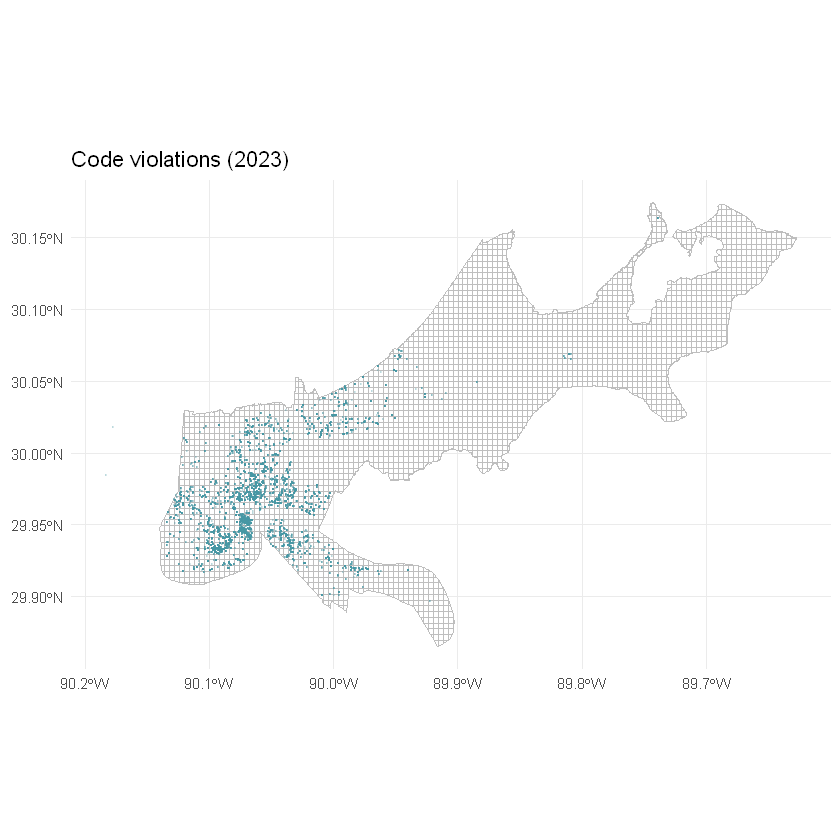

In [16]:
# load it back in
violations_sf <- readRDS('./data/violations.rds') %>%
    filter(extent.xmin >= -90.2)  # exclude a case outside of the landmass geometry

# plot it!
violations_map <- ggplot() +
    geom_sf(data = f.net, fill = 'transparent', color = 'grey', alpha = .8) +
    geom_sf(data = violations_sf, color = '#4495a2', size = .3, alpha = .2) +
    labs(title = 'Code violations (2023)') +
    theme_minimal()

print(violations_map)

# save the map
ggsave('./data/violations.png', 
       plot = violations_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

In [17]:
# clean the violations file
violations_sf <- st_make_valid(violations_sf)

# perform a spatial join between violations (points) and f.net (polygons)
multi_net <- st_join(violations_sf, f.net_valid, left = T) %>% 
  filter(!is.na(uniqueID))

# generate the violations net and perform a spatial join 
violations_net <- multi_net %>% 
  group_by(uniqueID) %>% 
  summarize(counter = n()) %>%
  mutate(counter = replace_na(counter, 0))  

# Perform a spatial join between violations (points) and f.net (polygons)
violations_net <- violations_sf %>%
  select() %>% 
  mutate(counter = 1) %>% 
  aggregate(., f.net_valid, sum) %>%
  mutate(counter = replace_na(counter, 0),
         uniqueID = rownames(.),    
         cvID = sample(nrow(f.net) %/% 24, 
                       size = nrow(f.net), 
                       replace = TRUE)
         )

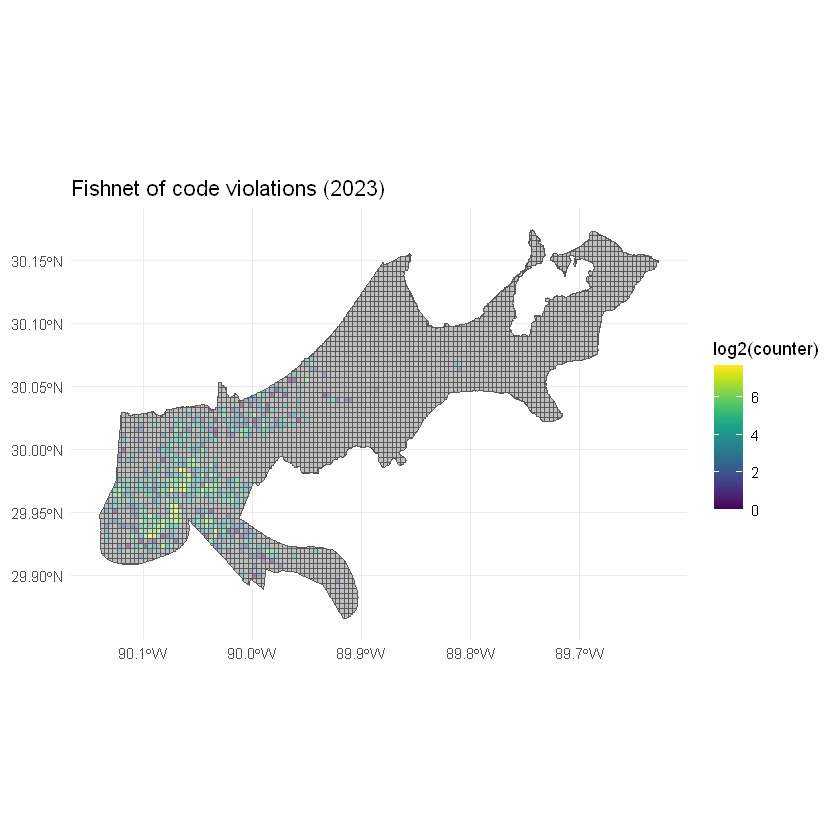

In [19]:
# let's look at an initial map!
violations_fishnet <- violations_net %>%
    ggplot(aes(fill = log2(counter))) +
    geom_sf(size = 0.2, alpha = 0.5) +
    scale_fill_viridis() +
    theme_minimal() + 
    labs(title = 'Fishnet of code violations (2023)')

violations_fishnet %>% print

ggsave('./data/violations-fishnet.png', 
       plot = violations_fishnet, 
       width = 8, 
       height = 6, 
       dpi = 300)

**Bring in chapter 66 lot abatements**

In [79]:
# find the code violations file
file_list = drive.ListFile({'q': "title='Grass_Cutting__Lot_Abatement_Chapter_66.csv'"}).GetList()

if file_list:  # If we found the file
    file = file_list[0]  # Get the first matching file
    print(f"Found file: {file['title']} (ID: {file['id']})")
    
    # Check if the file already exists locally
    if not os.path.exists('./data/chapter-66.csv'):
        # Download the file if it doesn't exist locally
        file.GetContentFile('./data/chapter-66.csv')  # Downloads to current directory
        print("File downloaded successfully!")
    else:
        print("File already exists locally.")
else:
    print("Could not find Grass_Cutting__Lot_Abatement_Chapter_66.csv in your Google Drive")

Found file: Grass_Cutting__Lot_Abatement_Chapter_66.csv (ID: 1w9OlBeYrI0LjVeSG6trTT_RZguxMLUCY)
File downloaded successfully!


In [35]:
# initial import and clean
ch66 <- read.csv('./data/chapter-66.csv') %>%
    pasteurize() %>%
    mutate(case_filed_date = mdy_hms(case_filed_date)) %>%
    filter(year(case_filed_date) == 2023 & longitude >= -91.18) %>%  # exclude cases outside of New Orleans
    distinct() %>%
    na.omit()

ch66 %>% glimpse()

Rows: 3,844
Columns: 29
$ open_closed                 <chr> "Open", "Closed", "Open", "Closed", "Close…
$ case_number                 <chr> "23-05000-ch66", "23-02819-ch66", "23-0917…
$ case_type                   <chr> "Chapter 66", "Chapter 66", "Chapter 66", …
$ address                     <chr> "3425 Saint Ferdinand St", "4145 Iberville…
$ current_status              <chr> "Mail Notice", "No Violation Found", "Viol…
$ current_status_date         <chr> "11/06/2023 11:09:19 Am", "05/29/2023 12:0…
$ case_filed_date             <dttm> 2023-08-25 09:38:09, 2023-05-26 09:59:06,…
$ initial_inspection_date     <chr> "08/25/2023 09:36:00 Am", "05/29/2023 12:0…
$ initial_inspection_result   <chr> "Complete", "No Violation", "Complete", "V…
$ violation_letter_sent       <chr> "", "", "", "", "", "", "", "", "", "", ""…
$ has_work_order              <chr> "False", "False", "False", "False", "False…
$ work_order_current_status   <chr> "", "", "", "", "", "", "", "", "", "", ""…
$ initial_work_o

In [23]:
# convert to sf object using existing coordinates
ch66_sf <- ch66 %>%
    st_as_sf(coords = c('longitude', 'latitude'), 
             crs = 4326, 
             agr = "constant") %>%
    na.omit() %>%
    st_make_valid()

# save the new sf file
ch66_sf %>% saveRDS('./data/ch66-sf.rds')

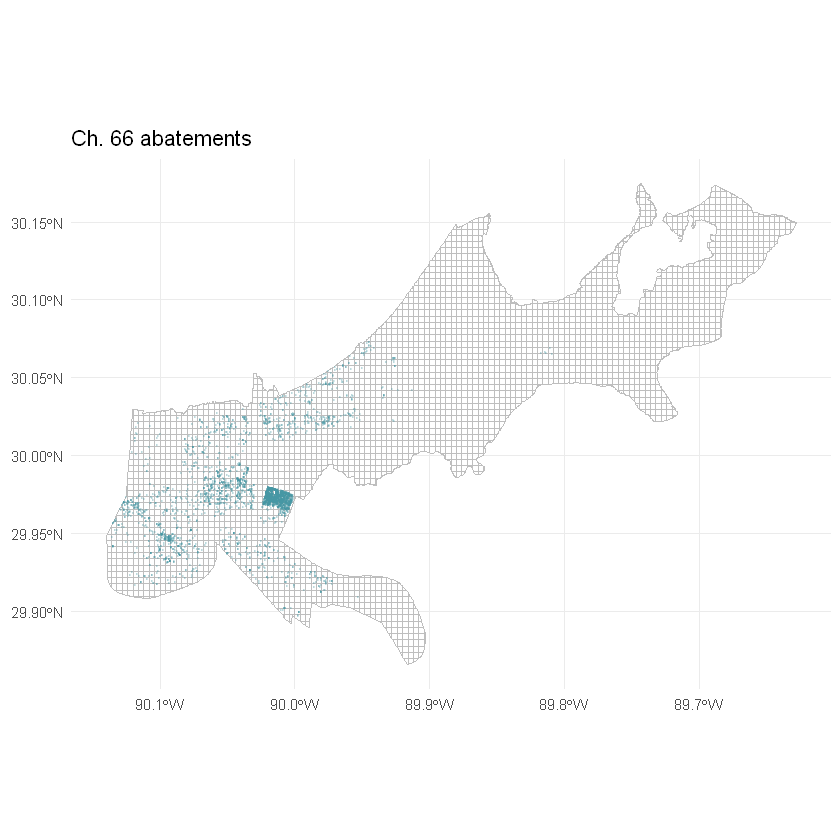

In [20]:
# read back in the ch66 sf file
ch66_sf <- readRDS('./data/ch66-sf.rds')

chh66_map <- ggplot(ch66_sf) +
    geom_sf(data = f.net, fill = 'transparent', color = 'grey', alpha = .8) +
    geom_sf(data = ch66_sf, color = '#4495a2', size = .3, alpha = .2) +
    labs(title = 'Ch. 66 abatements') +
    theme_minimal()

print(chh66_map)

ggsave('./data/ch66.png', 
       plot = chh66_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

In [21]:
# perform a spatial join between ch66 abatements (points) and f.net (polygons)
multi_net <- st_join(ch66_sf, f.net_valid, left = T) %>% 
  filter(!is.na(uniqueID))

# generate the ch66 abatements net and perform a spatial join 
ch66_net <- multi_net %>% 
  group_by(uniqueID) %>% 
  summarize(counter = n()) %>%
  mutate(counter = replace_na(counter, 0))  

# perform a spatial join between ch66 abatements (points) and f.net (polygons)
ch66_net <- ch66_sf %>%
  select() %>% 
  mutate(counter = 1) %>% 
  aggregate(., f.net_valid, sum) %>%
  mutate(counter = replace_na(counter, 0),
         uniqueID = rownames(.),    
         cvID = sample(nrow(f.net) %/% 24, 
                       size = nrow(f.net), 
                       replace = TRUE)
         )

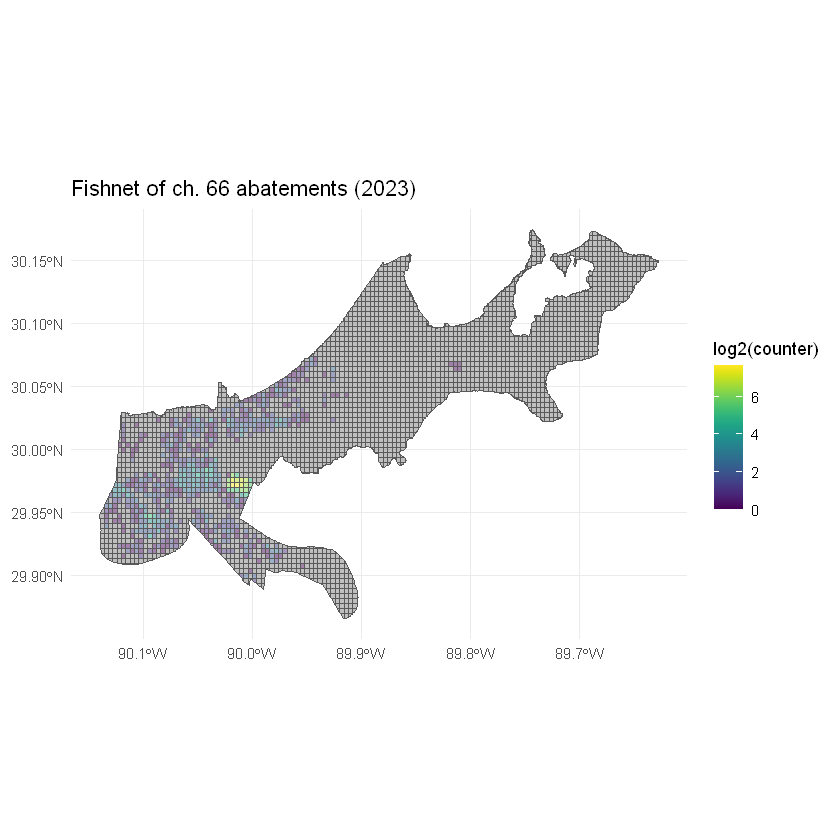

In [22]:
# let's look at an initial map!
ch66_fishnet <- ch66_net %>%
    ggplot(aes(fill = log2(counter))) +
    geom_sf(size = 0.2, alpha = 0.5) +
    scale_fill_viridis() +
    theme_minimal() + 
    labs(title = 'Fishnet of ch. 66 abatements (2023)')

ch66_fishnet %>% print

ggsave('./data/ch66-fishnet.png', 
       plot = ch66_fishnet, 
       width = 8, 
       height = 6, 
       dpi = 300)

**Look at market value analysis (MVA)**

In [27]:
# Create a visualization of MVA classes
mva <- ch66_sf %>%
    filter(str_detect(mva_class, 'Low|Tipping|High')) %>%  # exclude missing mva values
    mutate(mva_class = case_when(
            str_detect(mva_class, 'Low') ~ 'Low',
            str_detect(mva_class, 'Tipping') ~ 'Tipping',
            str_detect(mva_class, 'High') ~ 'High',
            TRUE ~ 'Unknown')) %>%
    mutate(mva_class = factor(mva_class, levels = c('High', 'Tipping', 'Low')))  # reorder the factor levels 

mva %>% saveRDS('./data/mva.rds')

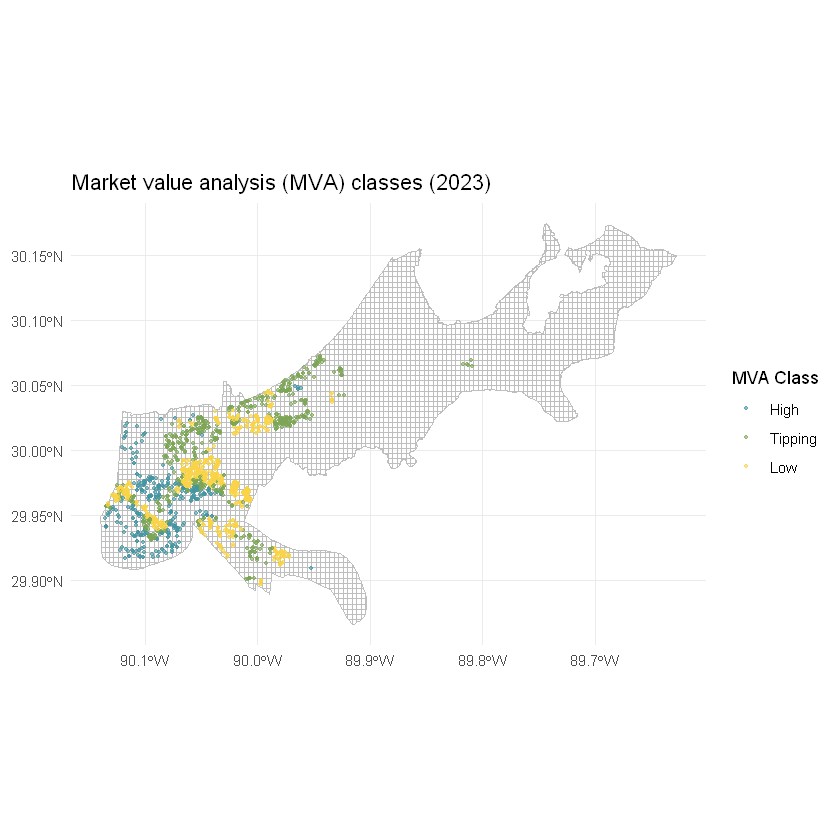

In [23]:
mva <- readRDS('./data/mva.rds')

mva_map <- ggplot(mva) +
    geom_sf(data = f.net, fill = 'transparent', color = 'grey', alpha = .6) +
    geom_sf(aes(color = mva_class), 
            size = 0.8, 
            alpha = 0.6) +
    scale_color_manual(values = c('Low' = '#f9d448', 'Tipping' = '#7ca655', 'High' = '#4495a2')) +
    theme_minimal() +
    labs(title = 'Market value analysis (MVA) classes (2023)',
         color = 'MVA Class')

print(mva_map)

ggsave('./data/mva.png', 
       plot = mva_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

In [24]:
# Clean the ch66_mva file and ensure correct spatial projection
mva_sf <- mva %>%
    st_transform(crs = 4326) %>%
    st_make_valid

# Use st_intersects to count how many points fall within each polygon
intersections <- st_intersects(f.net_valid, mva_sf, sparse = FALSE)

# Create the aggregated data frame with mva_class and counts
mva_net_aggregated <- tibble(uniqueID = f.net_valid$uniqueID) %>%
  mutate(
    # Count the number of points within each polygon
    total_counter = rowSums(intersections),
    # Use st_intersects to get the mva_class counts for each polygon
    mva_class = sapply(1:nrow(f.net_valid), function(i) {
      mva_classes <- mva_sf$mva_class[intersections[i, ]]
      if(length(mva_classes) > 0) {
        # Return the mode (most frequent) mva_class
        names(sort(table(mva_classes), decreasing = TRUE))[1]
      } else {
        NA
      }
    })
  )

# Merge the aggregated data with the original fishnet data to keep geometry and other attributes
mva_merged <- f.net_valid %>%
  bind_cols(mva_net_aggregated)

mva_merged$mva_class <- factor(mva_merged$mva_class, 
                                       levels = c("High", "Tipping", "Low"))

# save the merged mva file
mva_merged %>% saveRDS('./data/mva-merged.RDS')

New names:
• `uniqueID` -> `uniqueID...1`
• `uniqueID` -> `uniqueID...11`


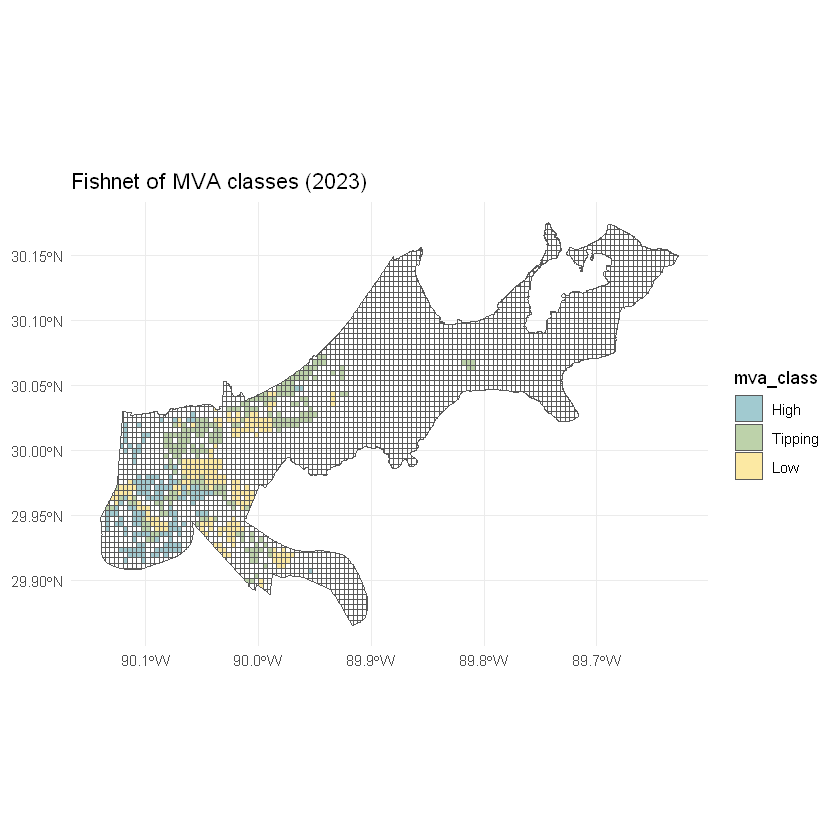

In [25]:
# load back in the merged mva file
mva_merged <- readRDS('./data/mva-merged.RDS')

# Plot the map with the mva_class coloring
mva_fishnet <- ggplot(mva_merged, aes(fill = mva_class)) +
  geom_sf(size = 0.2, alpha = 0.5) +
  scale_fill_manual(values = c('Low' = '#f9d448', 'Tipping' = '#7ca655', 'High' = '#4495a2'), 
  na.translate = FALSE  # Remove the N/A category from the legend
  ) +
  theme_minimal() + 
  labs(title = 'Fishnet of MVA classes (2023)')

mva_fishnet %>% print

ggsave('./data/mva-fishnet.png', 
       plot = mva_fishnet, 
       width = 8, 
       height = 6, 
       dpi = 300)

# **Step 6 - Munge census characteristics**

In [38]:
# establish census api
census_api_key(census_api_key)  # stored in .Renviron

options(tigris_use_cache = TRUE)

vars_check <- load_variables('2023', 'acs5', cache = T)

vars_check %>%
    filter(name %in% c(
  "B01003_001", "B01001_002", "B01001_026", "B02001_002", "B02001_003", 
  "B03002_012", "B15003_022", "B15003_023", "B19013_001", "B17001_002", 
  "B23025_005", "B23025_003", "C24010_001", "B25001_001", "B25002_003", 
  "B25003_002", "B25003_003", "B25077_001", "B11001_001", "B11001_006", 
  "C16001_001", "C16001_002", "B08301_001", "B08301_010"
)) %>% kable()

To install your API key for use in future sessions, run this function with `install = TRUE`.





|name       |label                                                                                        |concept                                                                            |geography |
|:----------|:--------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------|:---------|
|B01001_002 |Estimate!!Total:!!Male:                                                                      |Sex by Age                                                                         |NA        |
|B01001_026 |Estimate!!Total:!!Female:                                                                    |Sex by Age                                                                         |NA        |
|B01003_001 |Estimate!!Total                                                                              |Total Population                                                               

In [51]:
# establish census api
census_api_key('2aa769823f74a799fba67b1050ea77bef189a2a3')  # stored in .Renviron

options(tigris_use_cache = TRUE)

# Define variables to pull
variables <- c(
  "B01003_001", "B01001_002", "B01001_026", "B02001_002", "B02001_003", 
  "B03002_012", "B15003_022", "B15003_023", "B19013_001", "B17001_002", 
  "B23025_005", "B23025_003", "C24010_001", "B25001_001", "B25002_003", 
  "B25003_002", "B25003_003", "B25077_001", "B11001_001", "B11001_006", 
  "C16001_001", "C16001_002", "B08301_001", "B08301_010"
)

# Pull 2019-2023 5-year ACS data for Orleans Parish
census <- get_acs(
  geography = "tract", 
  variables = variables, 
  state = "LA", 
  county = "Orleans Parish", 
  year = 2023, 
  survey = "acs5", 
  geometry = TRUE, 
  output = "wide"
)

To install your API key for use in future sessions, run this function with `install = TRUE`.

Getting data from the 2019-2023 5-year ACS



In [52]:
# Get tract geometries from tigris
orleans_tracts <- tracts(state = "LA", county = "Orleans", year = 2024)

# Merge geometries with ACS data
census <- census %>%
  st_join(orleans_tracts %>% select(GEOID, ALAND), left = T)

In [53]:
# rename columns
census <- census %>%
  rename(
    total_population = B01003_001E,
    male_under_5 = B01001_002E,
    female_under_5 = B01001_026E,
    white_population = B02001_002E,
    black_population = B02001_003E,
    hispanic_population = B03002_012E,
    high_school_diploma = B15003_022E,
    some_college = B15003_023E,
    median_income = B19013_001E,
    poverty_count = B17001_002E,
    unemployed = B23025_005E,
    labor_force = B23025_003E,
    total_housing_units = B25001_001E,
    vacant_housing_units = B25002_003E,
    owner_occupied = B25003_002E,
    renter_occupied = B25003_003E,
    median_home_value = B25077_001E,
    total_households = B11001_001E,
    single_parent_households = B11001_006E,
    total_language = C16001_001E,
    english_only = C16001_002E,
    total_commuters = B08301_001E,
    public_transportation = B08301_010E,
    occupation_sex = C24010_001E
  )

# drop margin of error columns
census <- census %>%
  select(-ends_with("M")) %>%
  filter(!grepl(9900, NAME))

# calculate new variables
census <- census %>%
  mutate(
    population_density = total_population / (ALAND / 2589988), # Convert square meters to square miles
    poverty_rate = poverty_count / total_population * 100,
    unemployment_rate = unemployed / labor_force * 100,
    vacancy_rate = vacant_housing_units / total_housing_units * 100,
    renter_rate = renter_occupied / total_housing_units * 100,
    single_parent_rate = single_parent_households / total_households * 100,
    public_transportation_rate = public_transportation / total_commuters * 100
  )

In [44]:
census %>% glimpse()

Rows: 1,300
Columns: 29
$ GEOID.x                  <chr> "22071001900", "22071001900", "22071001900", …
$ NAME                     <chr> "Census Tract 19; Orleans Parish; Louisiana",…
$ total_population         <dbl> 1328, 1328, 1328, 1328, 1328, 1328, 1328, 183…
$ male_under_5             <dbl> 803, 803, 803, 803, 803, 803, 803, 1001, 1001…
$ female_under_5           <dbl> 525, 525, 525, 525, 525, 525, 525, 834, 834, …
$ white_population         <dbl> 407, 407, 407, 407, 407, 407, 407, 245, 245, …
$ black_population         <dbl> 785, 785, 785, 785, 785, 785, 785, 1339, 1339…
$ hispanic_population      <dbl> 86, 86, 86, 86, 86, 86, 86, 148, 148, 148, 14…
$ high_school_diploma      <dbl> 238, 238, 238, 238, 238, 238, 238, 137, 137, …
$ some_college             <dbl> 132, 132, 132, 132, 132, 132, 132, 57, 57, 57…
$ median_income            <dbl> 43542, 43542, 43542, 43542, 43542, 43542, 435…
$ poverty_count            <dbl> 522, 522, 522, 522, 522, 522, 522, 442, 442, …
$ unemployed    

In [58]:
# convert to sf object
census_sf <- census %>% 
    st_transform(crs = 4326)

# save the sf object
census_sf %>% saveRDS('./data/census-sf.rds')

In [26]:
# read back in the census sf object
census_sf <- readRDS('./data/census-sf.rds')

census_sf %>% glimpse()

Rows: 1,290
Columns: 36
$ GEOID.x                    <chr> "22071001900", "22071001900", "22071001900"…
$ NAME                       <chr> "Census Tract 19; Orleans Parish; Louisiana…
$ total_population           <dbl> 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1…
$ male_under_5               <dbl> 803, 803, 803, 803, 803, 803, 803, 1001, 10…
$ female_under_5             <dbl> 525, 525, 525, 525, 525, 525, 525, 834, 834…
$ white_population           <dbl> 407, 407, 407, 407, 407, 407, 407, 245, 245…
$ black_population           <dbl> 785, 785, 785, 785, 785, 785, 785, 1339, 13…
$ hispanic_population        <dbl> 86, 86, 86, 86, 86, 86, 86, 148, 148, 148, …
$ high_school_diploma        <dbl> 238, 238, 238, 238, 238, 238, 238, 137, 137…
$ some_college               <dbl> 132, 132, 132, 132, 132, 132, 132, 57, 57, …
$ median_income              <dbl> 43542, 43542, 43542, 43542, 43542, 43542, 4…
$ poverty_count              <dbl> 522, 522, 522, 522, 522, 522, 522, 442, 442…
$ unemployed    

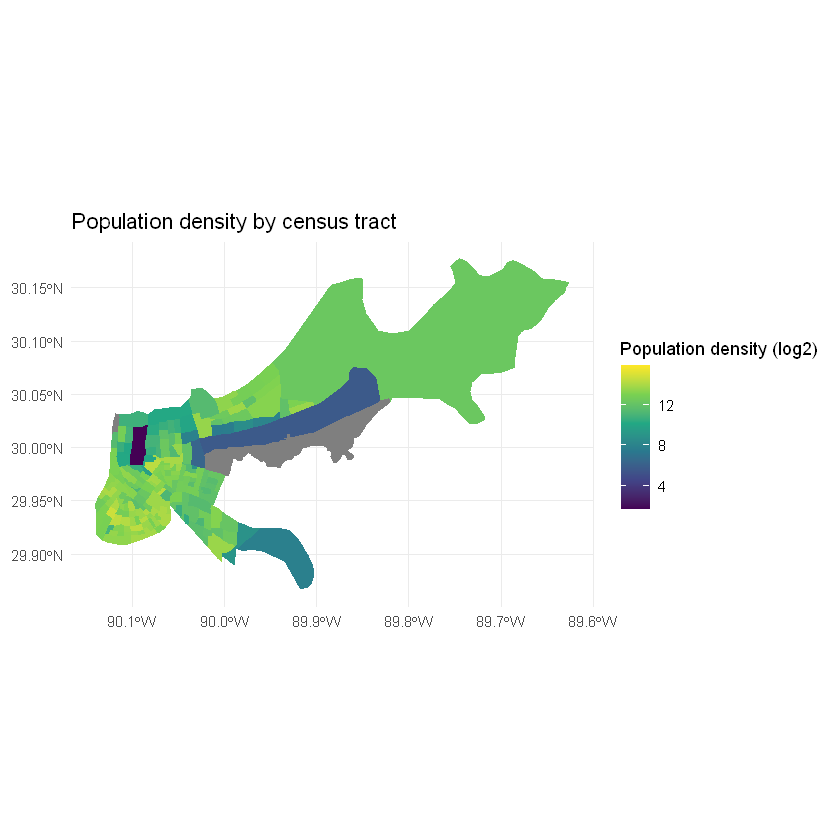

In [46]:
# visualize population density
population_map <- ggplot(census_sf) +
    geom_sf(aes(fill = log2(population_density)), color = NA) +
    scale_fill_viridis_c(name = "Population density (log2)") +
    theme_minimal() +
    labs(title = "Population density by census tract")

print(population_map)

# save the map
ggsave('./data/pop-density.png', 
       plot = population_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

In [27]:
# attempt to make a fishnet of census characteristics
# ensure polygon validity
census_sf <- st_make_valid(census_sf)

# Perform a spatial join between census tracts and fishnet polygons
multi_net_census <- st_join(census_sf, f.net_valid, left = TRUE) %>% 
  filter(!is.na(uniqueID))

# Aggregate census variables at the fishnet level
census_net <- multi_net_census %>% 
  group_by(uniqueID) %>%
  summarize(across(where(is.numeric), sum, na.rm = TRUE)) %>%
  mutate(uniqueID = rownames(.))

# Perform a final spatial join to attach aggregated census data to the fishnet
fishnet_census <- f.net_valid %>%
  st_join(census_net, left = TRUE)

Warning message:
"There was 1 warning in `summarize()`.
ℹ In argument: `across(where(is.numeric), sum, na.rm = TRUE)`.
ℹ In group 1: `uniqueID = "10032"`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))"


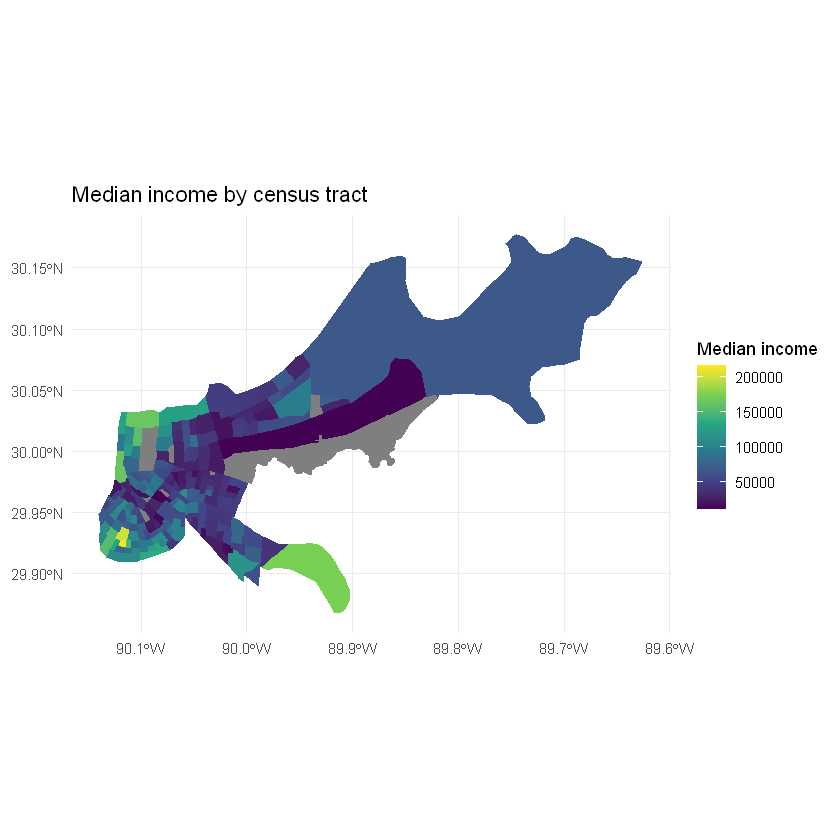

In [28]:
# visualize median income
income_map <- ggplot(census_sf) +
    geom_sf(aes(fill = median_income), color = NA) +
    scale_fill_viridis_c(name = "Median income") +
    theme_minimal() +
    labs(title = "Median income by census tract")

print(income_map)

# save the map
ggsave('./data/median-income.png', 
       plot = income_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

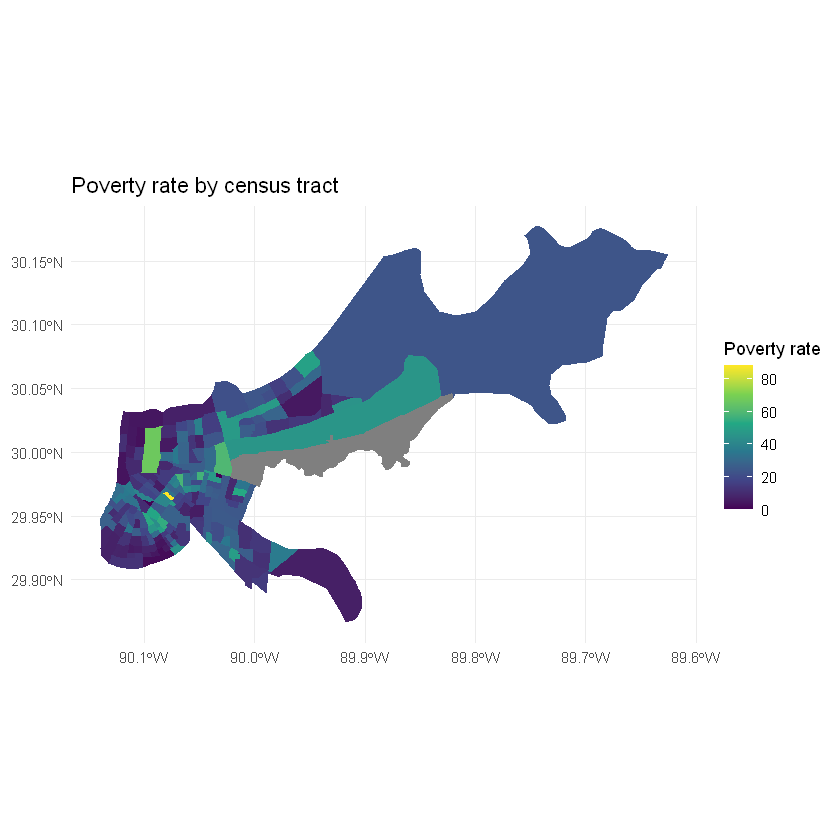

In [29]:
# visualize poverty rates
poverty_map <- ggplot(census_sf) +
    geom_sf(aes(fill = poverty_rate), color = NA) +
    scale_fill_viridis_c(name = "Poverty rate") +
    theme_minimal() +
    labs(title = "Poverty rate by census tract")

print(poverty_map)

# save the map
ggsave('./data/poverty-rate.png', 
       plot = poverty_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

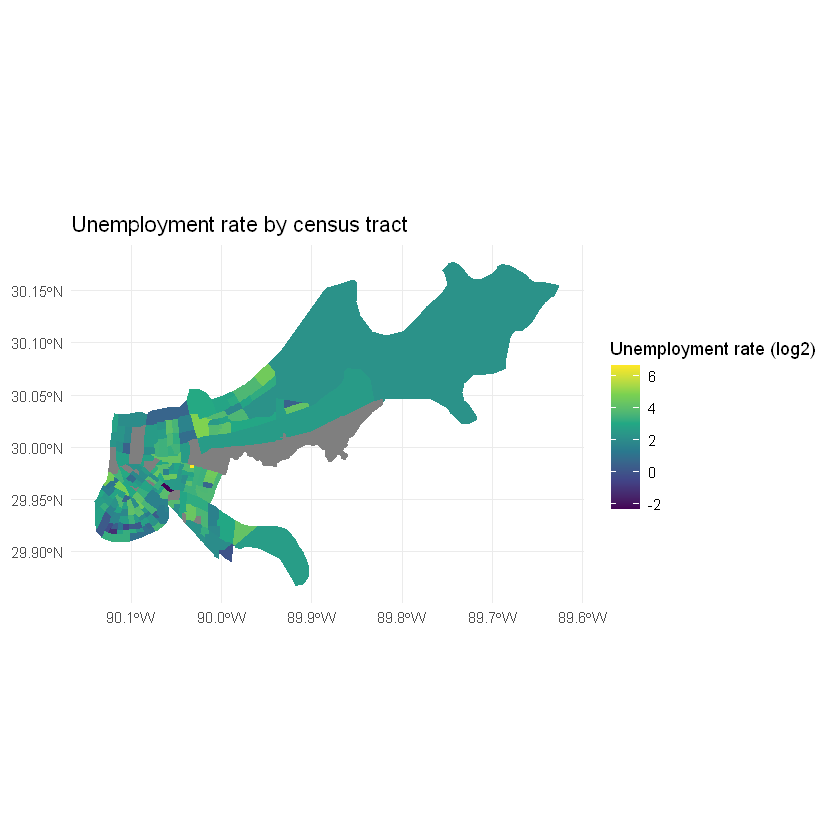

In [30]:
# visualize unemployment rates
unemployment_map <- ggplot(census_sf) +
    geom_sf(aes(fill = log2(unemployment_rate)), color = NA) +
    scale_fill_viridis_c(name = "Unemployment rate (log2)") +
    theme_minimal() +
    labs(title = "Unemployment rate by census tract")

print(unemployment_map)

# save the map
ggsave('./data/unemployment-rate.png', 
       plot = unemployment_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

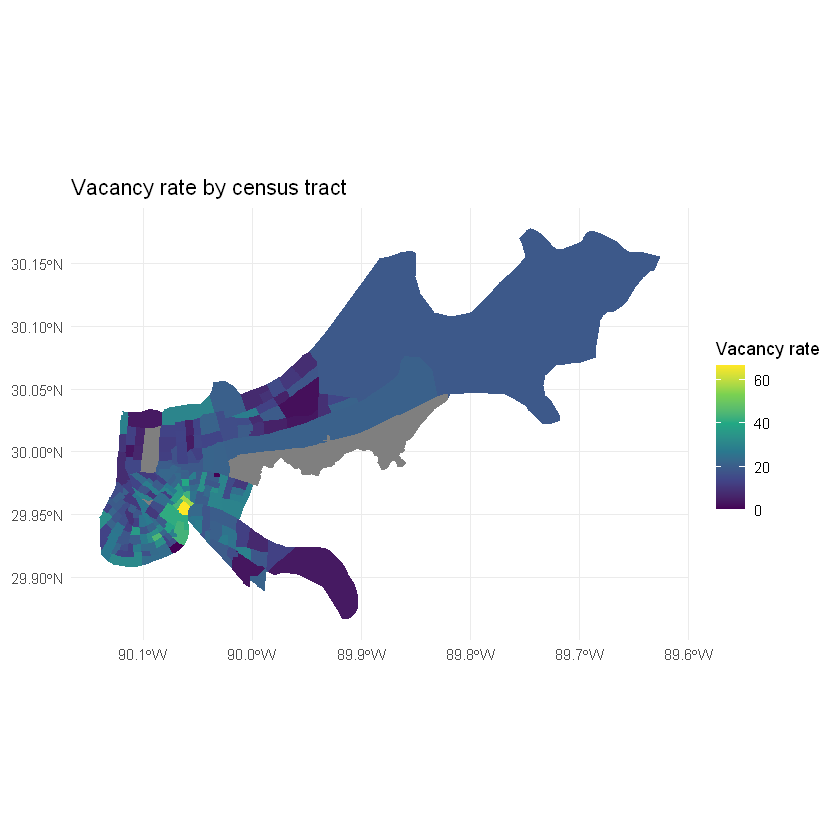

In [31]:
# visualize vacancy rates
vacancy_map <- ggplot(census_sf) +
    geom_sf(aes(fill = vacancy_rate), color = NA) +
    scale_fill_viridis_c(name = "Vacancy rate") +
    theme_minimal() +
    labs(title = "Vacancy rate by census tract")

print(vacancy_map)

# save the map
ggsave('./data/vacancy-rate.png', 
       plot = vacancy_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

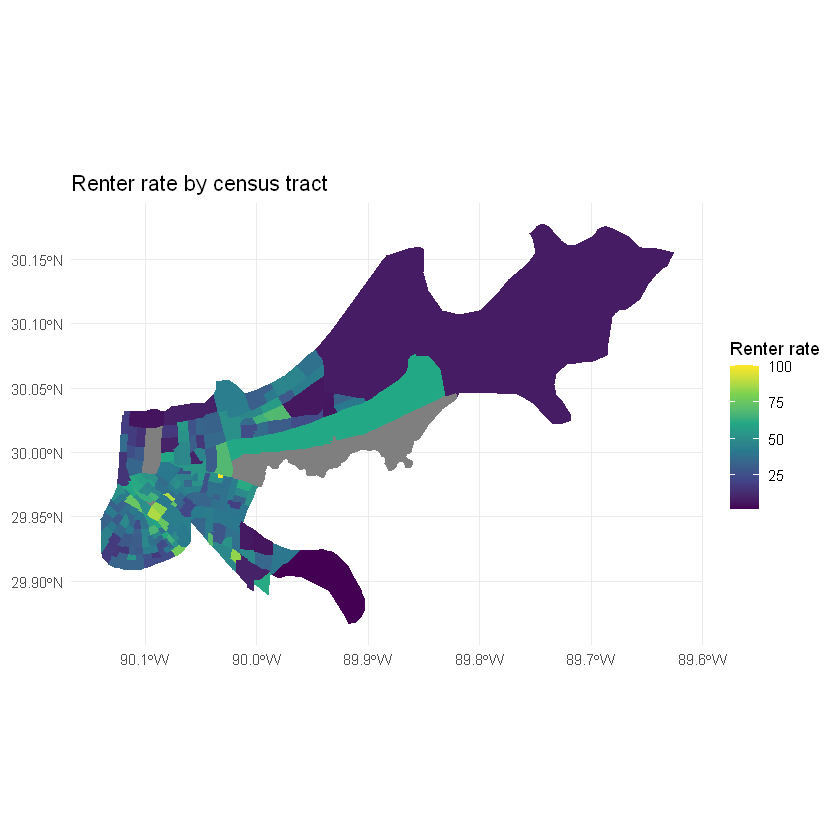

In [32]:
# visualize renter rates
renter_map <- ggplot(census_sf) +
    geom_sf(aes(fill = renter_rate), color = NA) +
    scale_fill_viridis_c(name = "Renter rate") +
    theme_minimal() +
    labs(title = "Renter rate by census tract")

print(renter_map)

# save the map
ggsave('./data/renter-rate.png', 
       plot = renter_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

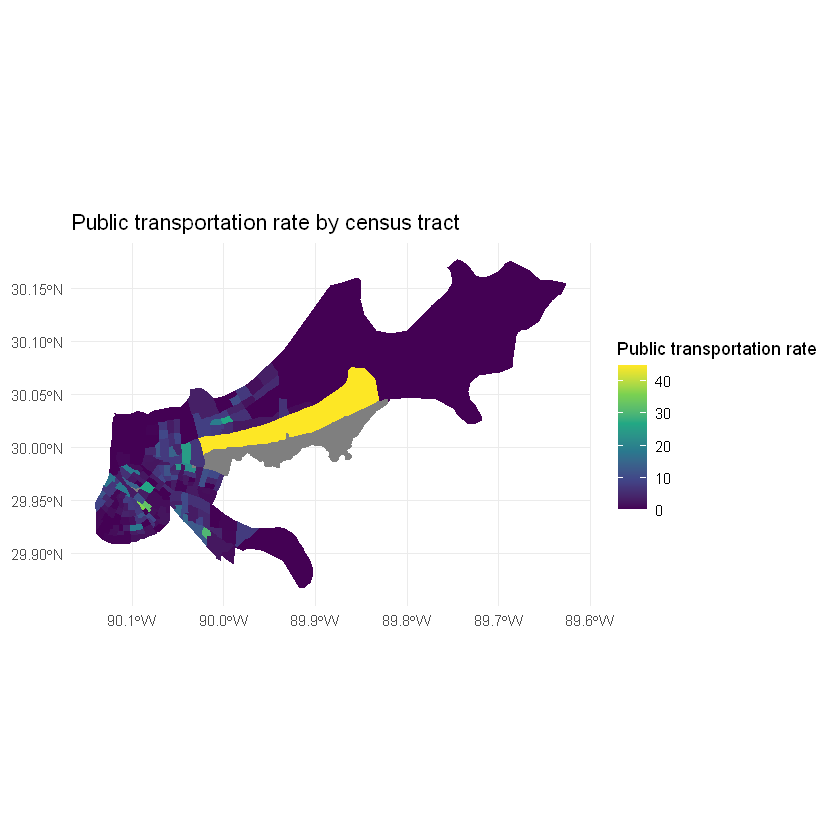

In [53]:
# visualize transportation rates
transportation_map <- ggplot(census_sf) +
    geom_sf(aes(fill = public_transportation_rate), color = NA) +
    scale_fill_viridis_c(name = "Public transportation rate") +
    theme_minimal() +
    labs(title = "Public transportation rate by census tract")

print(transportation_map)

# save the map
ggsave('./data/public-transportation-rate.png', 
       plot = transportation_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

# **Step 7 - Munge 311 calls**

In [33]:
# load in 311 calls dataset
path <- './data/311.csv'

if(!file.exists(path)) {
    write.csv(read.socrata('https://data.nola.gov/api/odata/v4/2jgv-pqrq'),
              file = path,
              row.names = FALSE)
}

# initial clean of 311 calls
three11 <- read.csv(path) %>%
    clean_names() %>%
    na.omit() %>%
    distinct()

# subset only 2023 calls
three11 <- three11 %>%
    mutate(date_created = ymd_hms(date_created)) %>%
    filter(year(date_created) == 2023)

# convert to spatial feature object
three11 <- three11 %>% 
  st_as_sf(coords = c('longitude', 'latitude'),
           
           crs = 4326, 
           agr = "constant") %>%        
  na.omit()

three11 %>% glimpse()

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `date_created = ymd_hms(date_created)`.
Caused by warning:
!  5 failed to parse."


Rows: 75,863
Columns: 18
$ service_request    <chr> "2023-958137", "2023-958322", "2023-958321", "2023-…
$ request_type       <chr> "Trash/Recycling", "Health Related Request", "Healt…
$ request_reason     <chr> "Missed Trash Pick-Up", "Noise Ordinance Complaint"…
$ date_created       <dttm> 2023-01-01 00:52:37, 2023-01-02 00:18:13, 2023-01-…
$ date_modified      <chr> "2024-12-22 21:44:18", "2024-12-22 21:33:31", "2024…
$ case_close_date    <chr> "2023-07-14 04:32:04", "2023-01-09 03:45:34", "2023…
$ request_status     <chr> "Closed", "Closed", "Closed", "Closed", "Closed", "…
$ responsible_agency <chr> "Department of Sanitation", "Health Department", "H…
$ final_address      <chr> "4137 General Ogden St, New Orleans, Louisiana, 701…
$ address_councildis <chr> "A", "D", "D", "A", "A", "D", "A", "C", "A", "A", "…
$ status             <chr> "Resolved", "Unfounded", "Unfounded", "Resolved", "…
$ contractor         <chr> "Richards Disposal", "", "", "Richards Disposal", "…
$ contractor_ac

In [34]:
# identify streetlight outages
lights <- three11 %>%
    filter(grepl('Streetlight', request_reason))

cat('lights:\n')
lights %>% glimpse()

lights:
Rows: 5,774
Columns: 18
$ service_request    <chr> "2023-958304", "2023-958299", "2023-958297", "2023-…
$ request_type       <chr> "Streetlights", "Streetlights", "Streetlights", "St…
$ request_reason     <chr> "Streetlight Outage/Malfunction", "Streetlight Outa…
$ date_created       <dttm> 2023-01-01 20:35:25, 2023-01-01 20:15:42, 2023-01-…
$ date_modified      <chr> "2024-12-22 21:26:00", "2024-12-22 21:36:53", "2024…
$ case_close_date    <chr> "2023-08-03 08:34:04", "2023-11-07 09:00:10", "2023…
$ request_status     <chr> "Closed", "Closed", "Closed", "Closed", "Closed", "…
$ responsible_agency <chr> "Department of Public Works", "Department of Public…
$ final_address      <chr> "4490 Baccich St", "2815 New Orleans St", "2028 Roy…
$ address_councildis <chr> "D", "D", "C", "A", "A", "C", "B", "C", "C", "B", "…
$ status             <chr> "Duplicate Request", "Resolved", "Resolved", "Resol…
$ contractor         <chr> "Legacy Professional Services", "Legacy Professiona…
$ contra

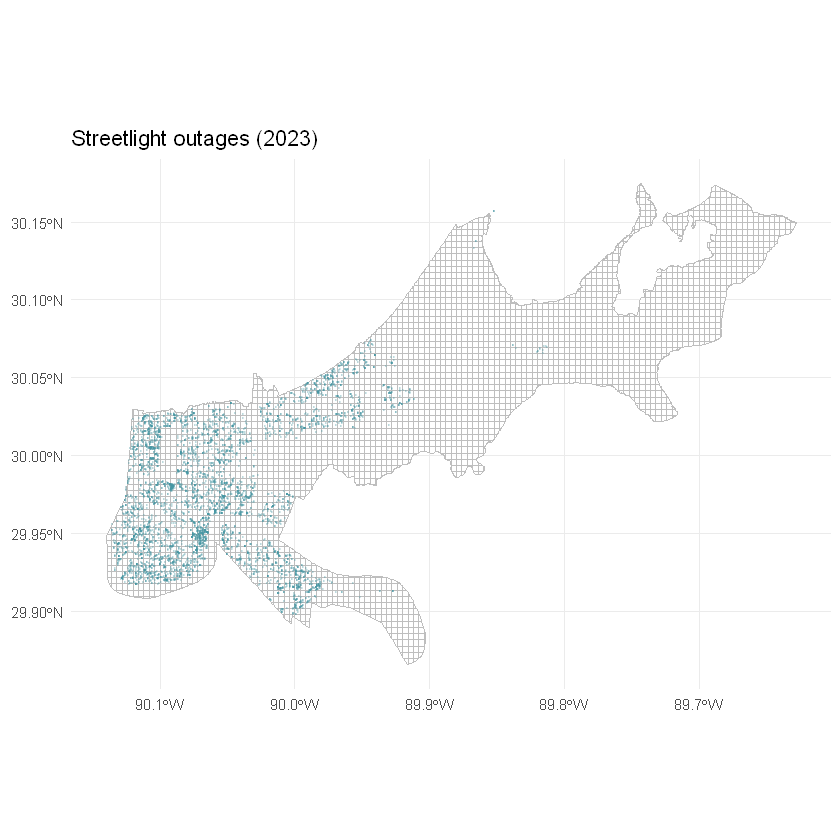

In [35]:
# plot streetlights
lights_map <- ggplot() +
    geom_sf(data = f.net, fill = 'transparent', color = 'grey', alpha = .8) +
    geom_sf(data = lights, color = '#4495a2', size = .3, alpha = .2) +
    labs(title = 'Streetlight outages (2023)') +
    theme_minimal()

lights_map %>% print

ggsave('./data/lights-map.png', 
       plot = lights_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

In [36]:
# perform a spatial join between streetlight outages (points) and f.net (polygons)
multi_net <- st_join(lights, f.net_valid, left = T) %>% 
  filter(!is.na(uniqueID))

# generate the streetlights net and perform a spatial join 
lights_net <- multi_net %>% 
  group_by(uniqueID) %>% 
  summarize(counter = n()) %>%
  mutate(counter = replace_na(counter, 0))  

# perform a spatial join between streetlight outages (points) and f.net (polygons)
lights_net <- lights %>%
  select() %>% 
  mutate(counter = 1) %>% 
  aggregate(., f.net_valid, sum) %>%
  mutate(counter = replace_na(counter, 0),
         uniqueID = rownames(.),    
         cvID = sample(nrow(f.net) %/% 24, 
                       size = nrow(f.net), 
                       replace = TRUE)
         )

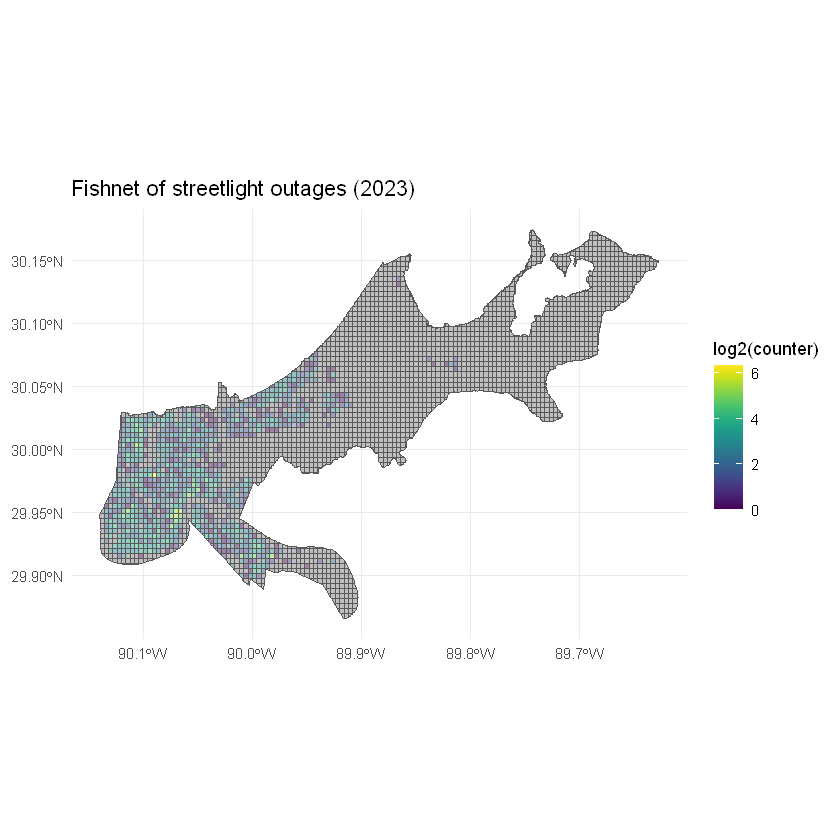

In [37]:
# let's look at an initial map!
lights_fishnet <- lights_net %>%
    ggplot(aes(fill = log2(counter))) +
    geom_sf(size = 0.2, alpha = 0.5) +
    scale_fill_viridis() +
    theme_minimal() + 
    labs(title = 'Fishnet of streetlight outages (2023)')

lights_fishnet %>% print

ggsave('./data/lights-fishnet.png', 
       plot = lights_fishnet, 
       width = 8, 
       height = 6, 
       dpi = 300)

In [38]:
# identify abandoned vehicles
vehicles <- three11 %>%
    filter(grepl('Junk Vehicles', request_reason)) %>%
    filter(final_x >= 3600000)  # remove OOB geometry

cat('\nvehicles:\n')
vehicles %>% glimpse()


vehicles:
Rows: 2,964
Columns: 18
$ service_request    <chr> "2023-958264", "2023-958263", "2023-958262", "2023-…
$ request_type       <chr> "Abandoned Vehicles", "Abandoned Vehicles", "Abando…
$ request_reason     <chr> "Abandoned/Junk Vehicles", "Abandoned/Junk Vehicles…
$ date_created       <dttm> 2023-01-01 15:43:30, 2023-01-01 15:41:41, 2023-01-…
$ date_modified      <chr> "2024-12-22 21:26:02", "2024-12-22 21:53:56", "2024…
$ case_close_date    <chr> "2023-11-06 08:37:06", "2023-01-02 07:35:29", "2023…
$ request_status     <chr> "Closed", "Closed", "Closed", "Closed", "Closed", "…
$ responsible_agency <chr> "Department of Public Works", "Department of Public…
$ final_address      <chr> "2015 N Galvez St", "1767 N Roman St", "1816 Annett…
$ address_councildis <chr> "D", "D", "D", "C", "C", "D", "C", "E", "C", "E", "…
$ status             <chr> "Resolved", "Resolved", "Resolved", "Resolved", "Re…
$ contractor         <chr> "", "", "", "", "", "", "", "", "", "", "", "", "",…
$ con

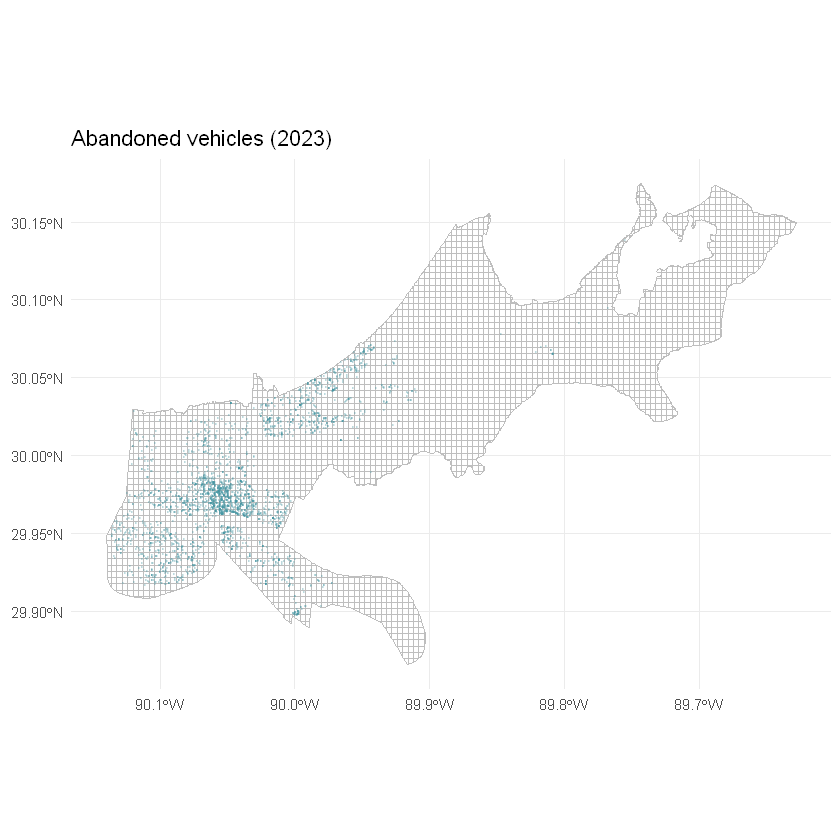

In [39]:
# plot abandoned vehicles
vehicles_map <- ggplot() +
    geom_sf(data = f.net, fill = 'transparent', color = 'grey', alpha = .8) +
    geom_sf(data = vehicles, color = '#4495a2', size = .3, alpha = .2) +
    labs(title = 'Abandoned vehicles (2023)') +
    theme_minimal()

vehicles_map %>% print

ggsave('./data/vehicles-map.png', 
       plot = vehicles_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

In [40]:
# perform a spatial join between abandoned vehicles (points) and f.net (polygons)
multi_net <- st_join(vehicles, f.net_valid, left = T) %>% 
  filter(!is.na(uniqueID))

# generate the abandoned vehicles net and perform a spatial join 
vehicles_net <- multi_net %>% 
  group_by(uniqueID) %>% 
  summarize(counter = n()) %>%
  mutate(counter = replace_na(counter, 0))  

# perform a spatial join between abandoned vehicles (points) and f.net (polygons)
vehicles_net <- vehicles %>%
  select() %>% 
  mutate(counter = 1) %>% 
  aggregate(., f.net_valid, sum) %>%
  mutate(counter = replace_na(counter, 0),
         uniqueID = rownames(.),    
         cvID = sample(nrow(f.net) %/% 24, 
                       size = nrow(f.net), 
                       replace = TRUE)
         )

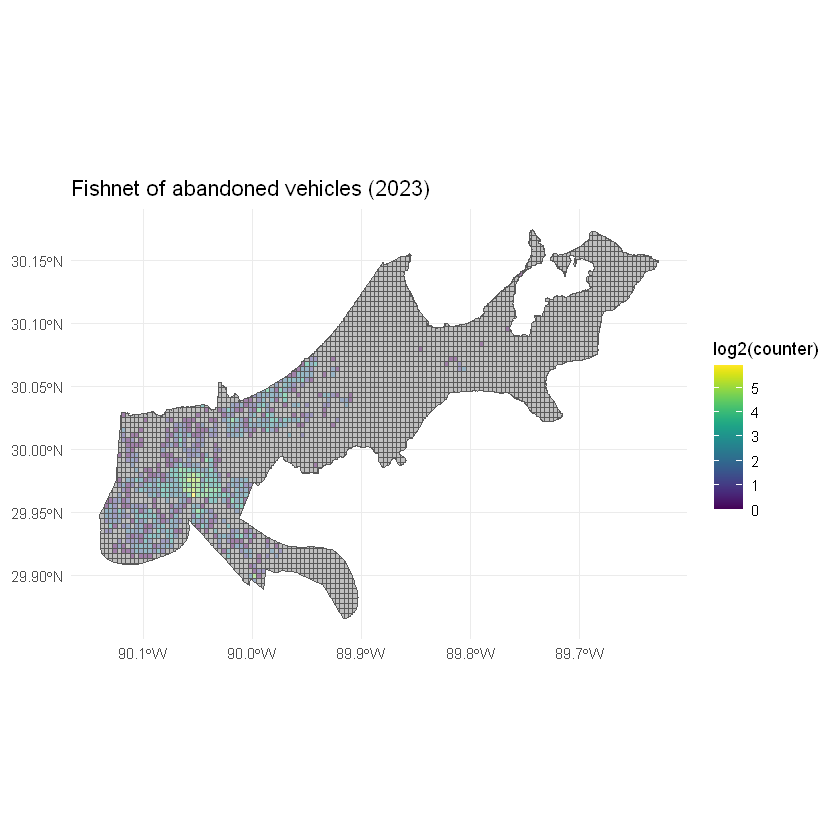

In [41]:
# let's look at an initial map!
vehicles_fishnet <- vehicles_net %>%
    ggplot(aes(fill = log2(counter))) +
    geom_sf(size = 0.2, alpha = 0.5) +
    scale_fill_viridis() +
    theme_minimal() + 
    labs(title = 'Fishnet of abandoned vehicles (2023)')

vehicles_fishnet %>% print

ggsave('./data/vehicles-fishnet.png', 
       plot = vehicles_fishnet, 
       width = 8, 
       height = 6, 
       dpi = 300)

# **Step 8 - Feature engineering**

In [44]:
# clean each factor to generate a grid of factor nets
lights_var <- lights %>% 
    mutate(lat = st_coordinates(.)[, 2],
           long = st_coordinates(.)[, 1], 
           Legend = 'Streetlight outages') %>%
    select(Y = lat, X = long, Legend)

vehicles_var <- vehicles %>% 
    mutate(lat = st_coordinates(.)[, 2],
           long = st_coordinates(.)[, 1], 
           Legend = 'Abandoned vehicles') %>% 
    select(Y = lat, X = long, Legend)

violations_var <- violations_sf %>% 
    select(Y = lat, X = long, Legend)

ch66_var <- ch66_sf %>% 
    mutate(lat = st_coordinates(.)[, 2],
           long = st_coordinates(.)[, 1], 
           Legend = 'Ch. 66 abatements') %>% 
    select(Y = lat, X = long, Legend)

mva_var <- mva_sf %>% 
    mutate(lat = st_coordinates(.)[, 2],
           long = st_coordinates(.)[, 1], 
           Legend = 'Market value assessments') %>% 
    select(Y = lat, X = long, Legend)

In [55]:
factors_net <- rbind(lights_var, vehicles_var, violations_var, 
                     ch66_var, mva_var) %>%
    st_join(., f.net_valid, join = st_within) %>%
    st_drop_geometry() %>%
    group_by(uniqueID, Legend) %>%
    summarize(count = n()) %>%
    full_join(select(f.net_valid, uniqueID, geometry)) %>%  
    spread(Legend, count, fill = 0) %>%
    st_sf() %>%
    select(uniqueID, geometry, everything(), -`<NA>`) %>% 
    na.omit() %>%
    ungroup()

factors_net_long <- gather(factors_net, Variable, value, -geometry, -uniqueID)

factors_net_long %>% saveRDS('./data/factors-net-long.RDS')

`summarise()` has grouped output by 'uniqueID'. You can override using the
`.groups` argument.
Joining with `by = join_by(uniqueID)`


In [56]:
factors_net_long <- readRDS('./data/factors-net-long.RDS')

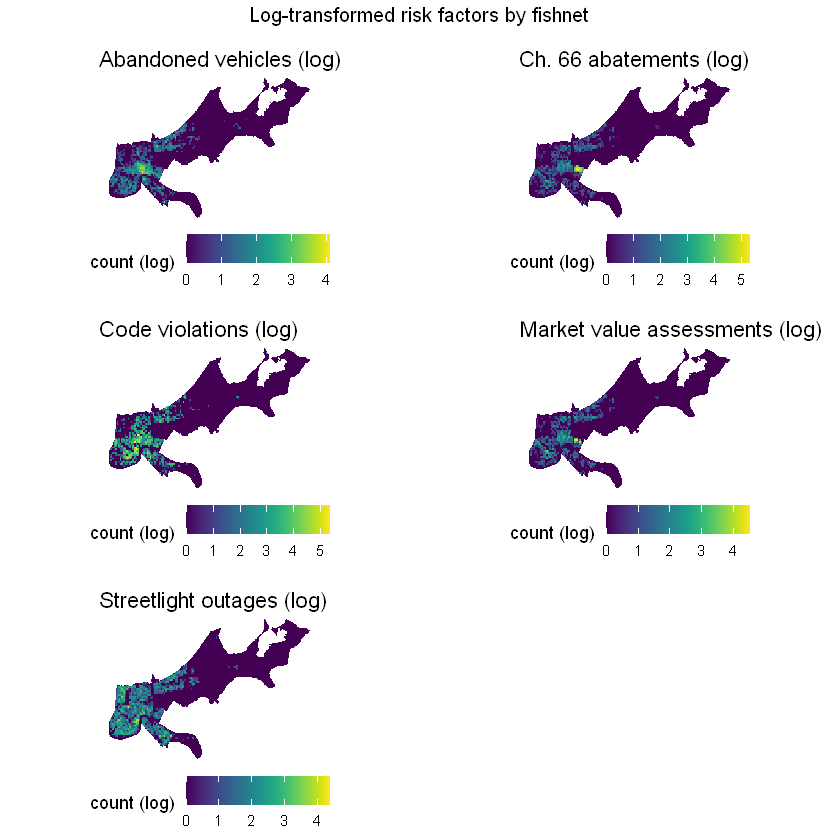

In [49]:
factors <- unique(factors_net_long$Variable)
mapList <- list()

for (i in factors){
    mapList[[i]] <- ggplot() +
        geom_sf(data = filter(factors_net_long, Variable == i), 
               aes(fill = log1p(as.numeric(value))),                                 # <- log transformation here
               color = NA) +
        scale_fill_viridis(name = 'count (log)') +
        labs(title = paste(i, "(log)")) +
        theme_void() + 
        theme(axis.text = element_blank(), 
              axis.ticks = element_blank(), 
              panel.grid = element_blank(),
              legend.position = "bottom",
              plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "lines")
        )
}

# Arrange maps with fewer columns to reduce spacing
do.call(grid.arrange, c(mapList, ncol = 2, top = 'Log-transformed risk factors by fishnet'))

# **Step 9 - Find *k* nearest neighbors**

In [51]:
# define {nn_function} for calculating nearest neighbors
nn_function <- function(measureFrom, measureTo, k) {
  nn <- get.knnx(measureTo, measureFrom, k)$nn.dist
  output <- as.data.frame(nn) %>%
    rownames_to_column(var = "thisPoint") %>%
    gather(points, point_distance, V1:ncol(.)) %>%
    arrange(as.numeric(thisPoint)) %>%
    group_by(thisPoint) %>%
    summarize(pointDistance = mean(point_distance)) %>%
    arrange(as.numeric(thisPoint)) %>%
    dplyr::select(-thisPoint) %>%
    as.data.frame()
  
  # Ensure output is a numeric vector for dist.nn
  names(output) <- c("dist.nn")
  output$dist.nn <- as.numeric(output$dist.nn)  # Convert to atomic numeric vector
  
  return(output$dist.nn)  # Return the numeric vector
}

In [52]:
st_c <- st_coordinates
st_coid <- st_centroid

factors_net_final <- factors_net %>%
    mutate(
      lights_var.nn = nn_function(st_c(st_coid(factors_net)), st_c(lights_var),2),
      vehicles_var.nn = nn_function(st_c(st_coid(factors_net)), st_c(vehicles_var),2),
      violations_var.nn = nn_function(st_c(st_coid(factors_net)), st_c(violations_var),2),
      ch66_var.nn = nn_function(st_c(st_coid(factors_net)), st_c(ch66_var),2),
      mva_var.nn = nn_function(st_c(st_coid(factors_net)), st_c(mva_var),2)
)

factors_net_final %>% glimpse()

Warning message:
"There were 5 warnings in `stopifnot()`.
The first warning was:
ℹ In argument: `lights_var.nn = nn_function(st_c(st_coid(factors_net)),
  st_c(lights_var), 2)`.
Caused by warning:
! st_centroid assumes attributes are constant over geometries
ℹ Run `dplyr::last_dplyr_warnings()` to see the 4 remaining warnings."


Rows: 3,334
Columns: 12
$ uniqueID                   <chr> "10032", "10033", "1064", "1065", "1066", "…
$ geometry                   <MULTIPOLYGON [°]> MULTIPOLYGON (((-89.74496 3...…
$ `Abandoned vehicles`       <dbl> 0, 0, 0, 0, 0, 4, 26, 1, 0, 0, 0, 0, 0, 0, …
$ `Ch. 66 abatements`        <dbl> 0, 0, 0, 2, 5, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0…
$ `Code violations`          <dbl> 0, 0, 0, 13, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, …
$ `Market value assessments` <dbl> 0, 0, 0, 2, 5, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0…
$ `Streetlight outages`      <dbl> 0, 0, 0, 12, 1, 6, 7, 2, 0, 0, 0, 0, 0, 0, …
$ lights_var.nn              <dbl> 0.1086048632, 0.1099089516, 0.0026629757, 0…
$ vehicles_var.nn            <dbl> 0.0596737489, 0.0602575500, 0.0118111376, 0…
$ violations_var.nn          <dbl> 0.011486315, 0.011116234, 0.003694395, 0.00…
$ ch66_var.nn                <dbl> 0.1250893822, 0.1259538625, 0.0032052810, 0…
$ mva_var.nn                 <dbl> 0.1250893822, 0.1259538625, 0.0032052810, 0…


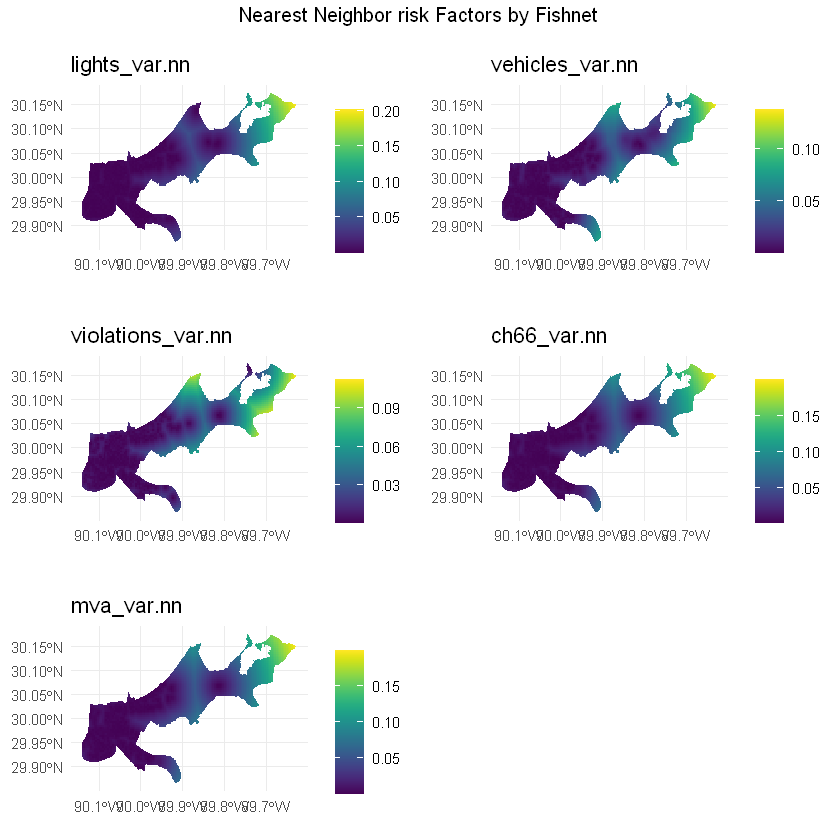

In [53]:
factors_net_long_nn <- 
  select(factors_net_final, ends_with(".nn")) %>%
    gather(Variable, value, -geometry)

vars <- unique(factors_net_long_nn$Variable)
mapList <- list()

for(i in vars){
  mapList[[i]] <- 
    ggplot() +
      geom_sf(data = filter(factors_net_long_nn, Variable == i), aes(fill=value), colour=NA) +
      scale_fill_viridis(name="") +
      labs(title=i) +
      theme_minimal()}

do.call(grid.arrange,c(mapList, ncol = 2, top = "Nearest Neighbor risk Factors by Fishnet"))

# **Step 10 - Generate the final net**

In [59]:
# generate the final net by joining the violent calls net with the factors new
final_net <-
  left_join(violent_net, st_drop_geometry(factors_net_final), by = 'uniqueID') 

final_net <-
  st_centroid(final_net) %>%
    st_join(select(neighborhoods, gnocdc_lab)) %>%
    st_join(select(nopd_districts, district)) %>%
      st_drop_geometry() %>%
      left_join(select(final_net, geometry, uniqueID)) %>%
      st_sf() %>%
  na.omit()

final_net %>% saveRDS('./data/final-net.RDS')

Warning message:
"st_centroid assumes attributes are constant over geometries"
Joining with `by = join_by(uniqueID)`


In [60]:
final_net <- readRDS('./data/final-net.RDS')

final_net %>% glimpse()

Rows: 3,299
Columns: 16
$ counter                    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ uniqueID                   <chr> "56", "57", "58", "184", "185", "186", "187…
$ cvID                       <int> 79, 107, 117, 130, 78, 68, 94, 94, 31, 42, …
$ `Abandoned vehicles`       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ `Ch. 66 abatements`        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ `Code violations`          <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ `Market value assessments` <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ `Streetlight outages`      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ lights_var.nn              <dbl> 0.04569562, 0.04659077, 0.04690347, 0.04058…
$ vehicles_var.nn            <dbl> 0.07327874, 0.07575709, 0.07825759, 0.06778…
$ violations_var.nn          <dbl> 0.02868686, 0.02956004, 0.02998648, 0.02371…
$ ch66_var.nn                <dbl> 0.06409686, 0.06630565, 0.06837949, 0.05836…
$ mva_var.nn    

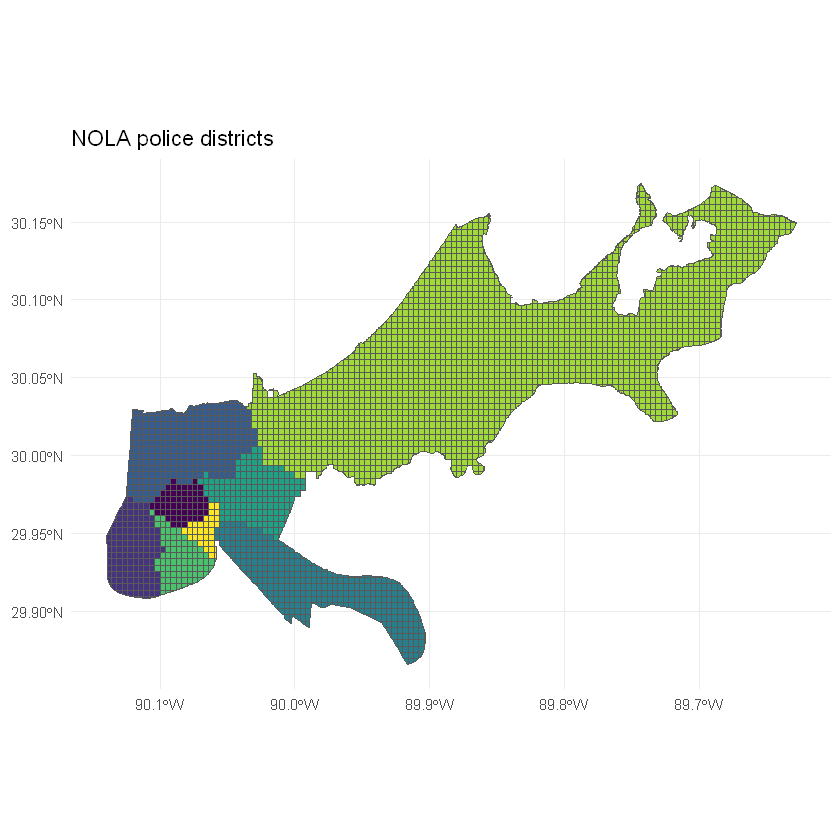

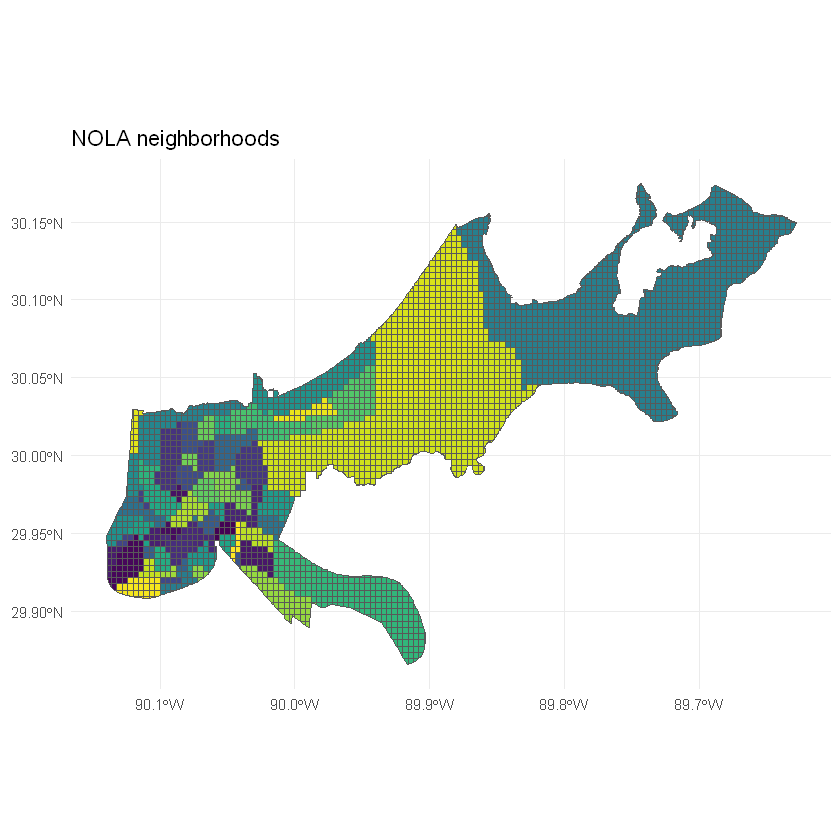

In [61]:
# map NOPD districts over the final net
nopd_districts_map <- ggplot() +
    geom_sf(data = final_net, aes(fill = district)) +
    scale_fill_viridis_d(name = "NOPD districts") +
    labs(title = 'NOLA police districts') +
    theme_minimal() +
    theme(legend.position = "none")   

print(nopd_districts_map)

ggsave('./data/nopd-districts-map.png', 
       plot = nopd_districts_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

# map neighborhoods over the final net
neighborhoods_map <- ggplot() +
    geom_sf(data = final_net, aes(fill = gnocdc_lab)) +
    scale_fill_viridis_d(name = "Neighborhoods") +
    labs(title = 'NOLA neighborhoods') +
    theme_minimal() +
    theme(legend.position = "none")    

print(neighborhoods_map)

ggsave('./data/neighborhoods-map.png', 
       plot = neighborhoods_map, 
       width = 8, 
       height = 6, 
       dpi = 300)

# **Step 11 - Local Moran's I**

In [62]:
# find contiguous neighbords
final_net_nb <- poly2nb(as_Spatial(final_net), queen=TRUE)

# generate spatial weights
final_net_weights <- nb2listw(final_net_nb, 
                              style = 'W', 
                              zero.policy = TRUE)

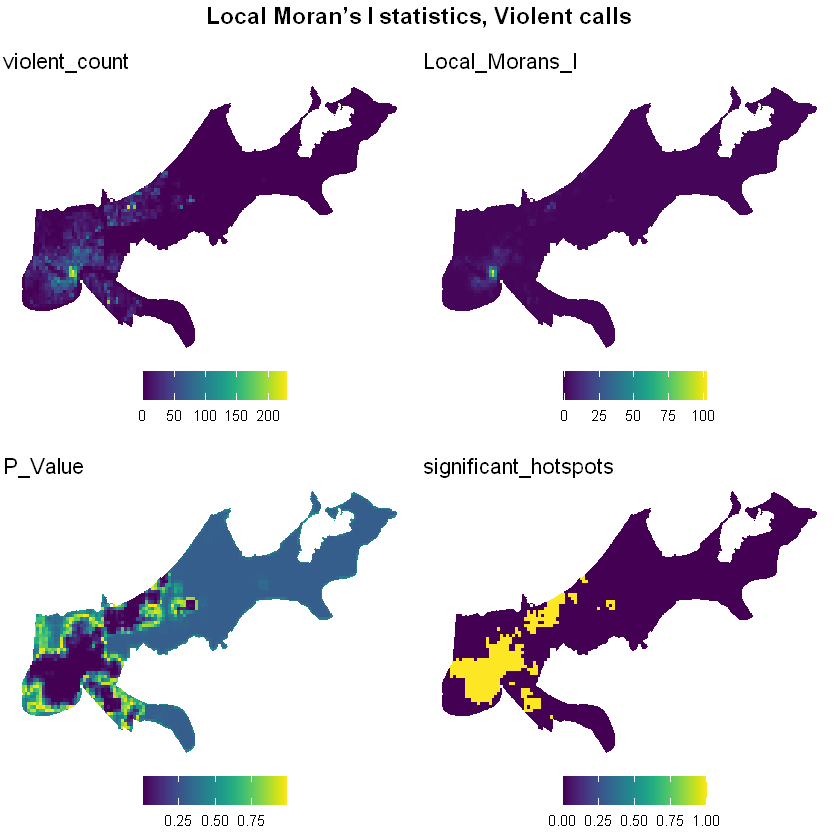

In [63]:
library(grid) # Ensure grid is loaded

final_net_morans <- localmoran(final_net$counter, final_net_weights) %>% 
  as.data.frame() %>% 
  cbind(as.data.frame(final_net)) %>% 
  st_sf() %>%
  select(
    violent_count = counter, 
    Local_Morans_I = Ii, 
    P_Value = `Pr(z != E(Ii))`
  ) %>%
  mutate(significant_hotspots = as.integer(P_Value <= 0.05)) %>%
  pivot_longer(-geometry, names_to = 'Variable', values_to = 'Value')

varList <- unique(final_net_morans$Variable) %>%
  setNames(., .) %>%
  lapply(function(var) {
    ggplot(filter(final_net_morans, Variable == var)) +
      geom_sf(aes(fill = Value), color = NA) +
      scale_fill_viridis(name = '') +
      labs(title = var) +
      theme_void() +
      theme(
        legend.position = 'bottom', 
        plot.margin = margin(2, 2, 2, 2) # Reducing white space
      )
  })

# Create title as a grob
title_grob <- textGrob('Local Moran’s I statistics, Violent calls', 
                        gp = gpar(fontsize = 14, fontface = 'bold'))

# Arrange plots in two columns
grid.arrange(
  do.call(arrangeGrob, c(varList, ncol = 2)), 
  top = title_grob
)

In [143]:
# calculate distances to significant hotspots
final_net <- final_net %>%
  mutate(violent_sig = ifelse(localmoran(counter, final_net_weights)[, 5] <= 1e-7, 1, 0)) %>%
  mutate(violent_sig_dist = 
           nn_function(st_coordinates(st_centroid(final_net)),
                       st_coordinates(st_centroid(
                         filter(final_net, violent_sig == 1))), 1))

Warning message:
"There were 2 warnings in `stopifnot()`.
The first warning was:
ℹ In argument: `violent_sig_dist = nn_function(...)`.
Caused by warning:
! st_centroid assumes attributes are constant over geometries
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."


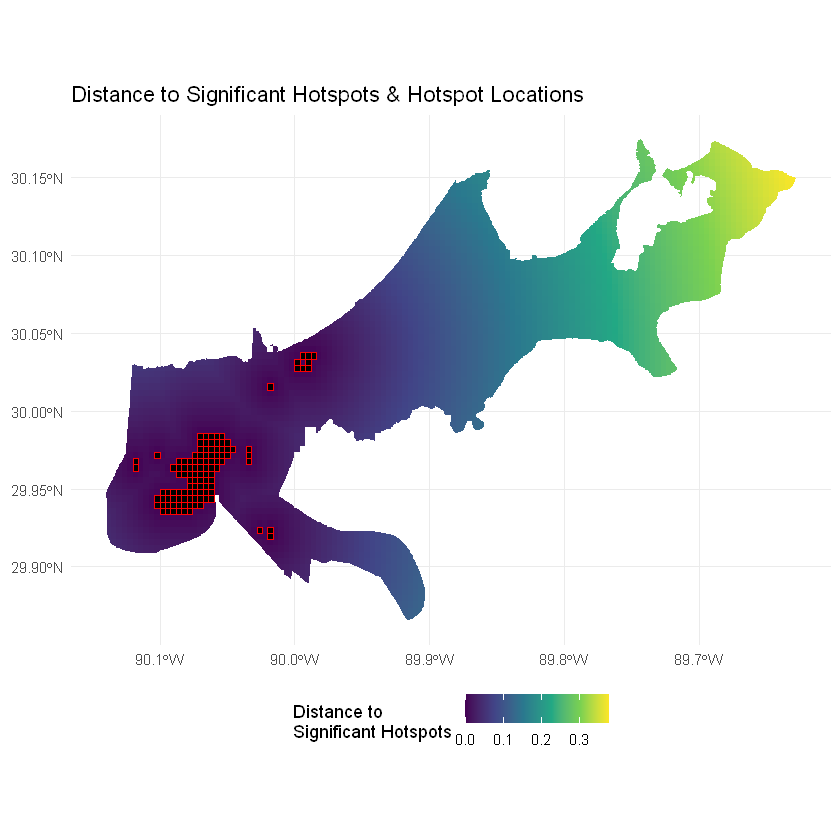

In [145]:
# map significant hotpots and distances
ggplot() +
  geom_sf(data = final_net, aes(fill = violent_sig_dist), color = NA) +
  geom_sf(data = filter(final_net, violent_sig == 1), 
          color = "red", size = 1.5, shape = 21, fill = "black") +
  scale_fill_viridis_c(name = "Distance to \nSignificant Hotspots") +
  labs(title = "Distance to Significant Hotspots & Hotspot Locations") +
  theme_void() +
  theme(legend.position = "bottom")

In [64]:
# Find local Moran's I for each call type
# Function to calculate Local Moran's I and create hotspot map for a specific call type
create_morans_map <- function(cfs_data, call_type, f_net) {
  # Filter data for specific call type
  type_data <- cfs_data %>%
    filter(predicted_category == call_type)
  
  # Create points-in-polygons count
  type_net <- type_data %>%
    select() %>%
    mutate(counter = 1) %>%
    aggregate(., f_net, sum) %>%
    mutate(counter = replace_na(counter, 0),
           uniqueID = rownames(.),
           cvID = sample(nrow(f_net) %/% 24,
                        size = nrow(f_net),
                        replace = TRUE))
  
  # Find contiguous neighbors
  type_nb <- poly2nb(as_Spatial(type_net), queen=TRUE)
  
  # Generate spatial weights
  type_weights <- nb2listw(type_nb,
                          style = 'W',
                          zero.policy = TRUE)
  
  # Calculate Local Moran's I
  type_morans <- localmoran(type_net$counter, type_weights) %>%
    as.data.frame() %>%
    cbind(as.data.frame(type_net)) %>%
    st_sf()
  
  # Calculate distances to significant hotspots
  type_net_final <- type_net %>%
    mutate(sig = ifelse(localmoran(counter, type_weights)[, 5] <= 1e-7, 1, 0))
  
  # Only calculate distances if there are significant hotspots
  if(sum(type_net_final$sig, na.rm = TRUE) > 0) {
    type_net_final <- type_net_final %>%
      mutate(sig_dist = nn_function(
        st_coordinates(st_centroid(type_net_final)),
        st_coordinates(st_centroid(filter(type_net_final, sig == 1))), 
        1))
  } else {
    type_net_final$sig_dist <- 0
  }
  
  # Create the map
  hotspot_map <- ggplot() +
    geom_sf(data = type_net_final, 
            aes(fill = sig_dist), 
            color = NA) +
    geom_sf(data = filter(type_net_final, sig == 1),
            color = "red", 
            size = 1.5, 
            shape = 21, 
            fill = "black") +
    scale_fill_viridis_c(
      name = "Distance to\nSignificant Hotspots",
      option = "magma"
    ) +
    labs(title = paste(call_type, "Calls - Significant Hotspots")) +
    theme_void() +
    theme(
      plot.title = element_text(size = 12, face = "bold", hjust = 0.5),
      legend.position = "bottom"
    )
  
  return(list(
    morans = type_morans,
    net_final = type_net_final,
    map = hotspot_map
  ))
}

# Get unique call types
call_types <- unique(cfs_final$predicted_category)

# Create maps for each call type
morans_maps <- list()
for(type in call_types) {
  morans_maps[[type]] <- create_morans_map(cfs_final, type, f.net_valid)
  
  # Save each map
  ggsave(
    paste0('./data/hotspots-', tolower(gsub(" ", "-", type)), '.png'),
    plot = morans_maps[[type]]$map,
    width = 8,
    height = 6,
    dpi = 300
  )
}

# Create a grid of all maps
map_grid <- do.call(gridExtra::grid.arrange, 
                   c(lapply(morans_maps, function(x) x$map), 
                     ncol = 2))

# Save the grid
ggsave('./data/hotspots-all.png',
       plot = map_grid,
       width = 16,
       height = 24,
       dpi = 300)

# **Step 12 - Test correlation of features**

In [69]:
# Neighborhood-level Analysis
# Aggregate violent calls to neighborhoods
neighborhood_crimes <- st_join(violations_sf, neighborhoods) %>%
  group_by(gnocdc_lab) %>%
  summarize(violent_count = n()) %>%
  st_join(neighborhoods, left = T)

In [70]:
# Aggregate risk factors to neighborhoods
# First, create individual neighborhood summaries
lights_by_neighborhood <- st_join(lights, neighborhoods) %>%
  group_by(gnocdc_lab) %>%
  summarize(streetlight_outages = n()) %>%
  st_drop_geometry()

vehicles_by_neighborhood <- st_join(vehicles, neighborhoods) %>%
  group_by(gnocdc_lab) %>%
  summarize(abandoned_vehicles = n()) %>%
  st_drop_geometry()

violations_by_neighborhood <- st_join(violations_sf, neighborhoods) %>%
  group_by(gnocdc_lab) %>%
  summarize(code_violations = n()) %>%
  st_drop_geometry()

ch66_by_neighborhood <- st_join(ch66_sf, neighborhoods) %>%
  group_by(gnocdc_lab) %>%
  summarize(lot_abatements = n()) %>%
  st_drop_geometry()

mva_by_neighborhood <- st_join(mva_sf, neighborhoods) %>% 
  group_by(gnocdc_lab) %>%
  summarize(mva_class = n()) %>%
  st_drop_geometry()

# Now combine them using left_join
neighborhood_risks <- lights_by_neighborhood %>%
  left_join(vehicles_by_neighborhood, by = "gnocdc_lab") %>%
  left_join(violations_by_neighborhood, by = "gnocdc_lab") %>%
  left_join(ch66_by_neighborhood, by = "gnocdc_lab") %>%
  left_join(mva_by_neighborhood, by = "gnocdc_lab") %>%
  mutate(across(where(is.numeric), ~replace_na(., 0))) 

In [154]:
census_sf %>% glimpse()

Rows: 1,290
Columns: 36
$ GEOID.x                    <chr> "22071001900", "22071001900", "22071001900"…
$ NAME                       <chr> "Census Tract 19; Orleans Parish; Louisiana…
$ total_population           <dbl> 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1…
$ male_under_5               <dbl> 803, 803, 803, 803, 803, 803, 803, 1001, 10…
$ female_under_5             <dbl> 525, 525, 525, 525, 525, 525, 525, 834, 834…
$ white_population           <dbl> 407, 407, 407, 407, 407, 407, 407, 245, 245…
$ black_population           <dbl> 785, 785, 785, 785, 785, 785, 785, 1339, 13…
$ hispanic_population        <dbl> 86, 86, 86, 86, 86, 86, 86, 148, 148, 148, …
$ high_school_diploma        <dbl> 238, 238, 238, 238, 238, 238, 238, 137, 137…
$ some_college               <dbl> 132, 132, 132, 132, 132, 132, 132, 57, 57, …
$ median_income              <dbl> 43542, 43542, 43542, 43542, 43542, 43542, 4…
$ poverty_count              <dbl> 522, 522, 522, 522, 522, 522, 522, 442, 442…
$ unemployed    

In [71]:
# 1. Prepare census data for neighborhoods
census_neighborhoods <- st_interpolate_aw(
  select(census_sf, median_income, poverty_rate, unemployment_rate, 
         vacancy_rate, renter_rate, population_density),
  neighborhoods,
  extensive = FALSE
) %>%
  # Add back neighborhood names
  mutate(gnocdc_lab = neighborhoods$gnocdc_lab)

# 2. Create base neighborhood dataset with geometries
neighborhood_final <- neighborhoods %>%
  select(gnocdc_lab, geometry)

Warning message in st_interpolate_aw.sf(select(census_sf, median_income, poverty_rate, :
"st_interpolate_aw assumes attributes are constant or uniform over areas of x"


In [72]:
# 3. Add violent crimes count
violent_counts <- st_join(violations_sf, neighborhoods) %>%
  group_by(gnocdc_lab) %>%
  summarize(violent_count = n()) %>%
  st_drop_geometry()

# 4. Add risk factors (already created)
neighborhood_final <- neighborhood_final %>%
  left_join(violent_counts, by = "gnocdc_lab") %>%
  left_join(neighborhood_risks, by = "gnocdc_lab") %>%
  left_join(st_drop_geometry(census_neighborhoods), by = "gnocdc_lab") %>%
  # Replace NAs with 0 for count variables and scale all numeric columns
  mutate(
    across(c(violent_count, streetlight_outages, abandoned_vehicles, 
             code_violations, lot_abatements), ~replace_na(., 0)),
    across(where(is.numeric), ~scale(.) %>% as.vector)
  )

In [73]:
# First, let's examine our data
neighborhood_final %>% 
  st_drop_geometry() %>%
  select(-gnocdc_lab) %>%
  summary()

# Check for NA values
neighborhood_final %>%
  st_drop_geometry() %>%
  select(-gnocdc_lab) %>%
  sapply(function(x) sum(is.na(x)))

# Try correlation with pairwise complete observations
neighborhood_correlations <- neighborhood_final %>%
  st_drop_geometry() %>%
  select(-gnocdc_lab) %>%
  # Remove any columns that are all NA
  select_if(function(x) !all(is.na(x))) %>%
  cor(use = "pairwise.complete.obs") %>%
  as.data.frame()

# Check the structure of our correlation matrix
str(neighborhood_correlations)

 violent_count     streetlight_outages abandoned_vehicles code_violations  
 Min.   :-0.7605   Min.   :-1.0956     Min.   :-0.7284    Min.   :-0.7605  
 1st Qu.:-0.5856   1st Qu.:-0.5965     1st Qu.:-0.5337    1st Qu.:-0.5856  
 Median :-0.2532   Median :-0.3435     Median :-0.3125    Median :-0.2532  
 Mean   : 0.0000   Mean   : 0.0000     Mean   : 0.0000    Mean   : 0.0000  
 3rd Qu.: 0.1951   3rd Qu.: 0.3264     3rd Qu.: 0.0150    3rd Qu.: 0.1951  
 Max.   : 4.7328   Max.   : 4.0045     Max.   : 4.4755    Max.   : 4.7328  
                                                                           
 lot_abatements       mva_class        median_income      poverty_rate     
 Min.   :-0.26003   Min.   :-0.58910   Min.   :-1.4504   Min.   :-1.53261  
 1st Qu.:-0.22104   1st Qu.:-0.47207   1st Qu.:-0.7835   1st Qu.:-0.75225  
 Median :-0.16986   Median :-0.24700   Median :-0.1886   Median :-0.05464  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.00000  
 3rd Qu.:-0.

violent_count streetlight_outages  abandoned_vehicles     code_violations 
                  0                   0                   0                   0 
     lot_abatements           mva_class       median_income        poverty_rate 
                  0                   1                  26                   4 
  unemployment_rate        vacancy_rate         renter_rate  population_density 
                  8                  15                  15                  72

'data.frame':	11 obs. of  11 variables:
 $ violent_count      : num  1 0.371 0.567 1 0.189 ...
 $ streetlight_outages: num  0.3708 1 0.45 0.3708 0.0854 ...
 $ abandoned_vehicles : num  0.567 0.45 1 0.567 0.205 ...
 $ code_violations    : num  1 0.371 0.567 1 0.189 ...
 $ lot_abatements     : num  0.1887 0.0854 0.205 0.1887 1 ...
 $ mva_class          : num  0.485 0.266 0.519 0.485 0.876 ...
 $ median_income      : num  -0.353 0.116 -0.289 -0.353 -0.463 ...
 $ poverty_rate       : num  0.2691 -0.0693 0.1753 0.2691 0.3397 ...
 $ unemployment_rate  : num  0.0209 -0.154 0.0435 0.0209 0.1077 ...
 $ vacancy_rate       : num  0.2617 -0.0108 0.0906 0.2617 -0.0486 ...
 $ renter_rate        : num  0.105 -0.266 0.045 0.105 0.125 ...


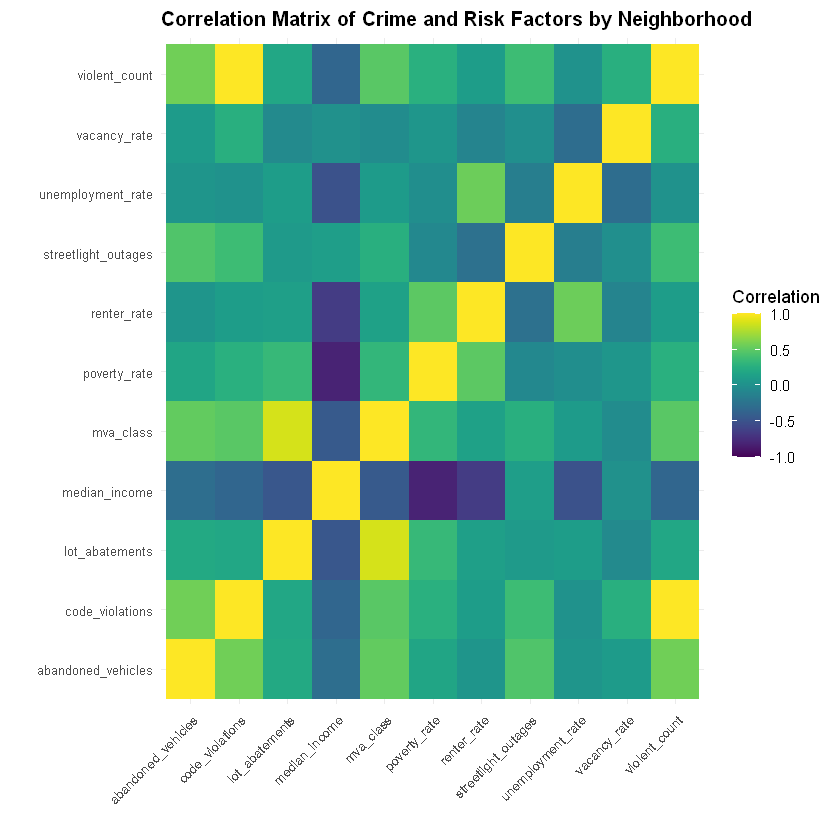

In [74]:
# First, let's clean the data for correlation analysis
correlation_data <- neighborhood_final %>%
  st_drop_geometry() %>%
  select(-gnocdc_lab, -population_density) %>%  # Remove population_density due to all NAs
  select_if(function(x) !all(is.na(x)))        # Remove any columns that are all NA

# Calculate correlations with pairwise complete observations
neighborhood_correlations <- cor(correlation_data, 
                               use = "pairwise.complete.obs") %>%
  as.data.frame()

# Convert to long format for plotting
correlation_long <- neighborhood_correlations %>%
  rownames_to_column("Var1") %>%
  gather(key = "Var2", value = "Correlation", -Var1)

# Create correlation heatmap
correlation_heatmap <- ggplot(correlation_long, 
       aes(x = Var1, y = Var2, fill = Correlation)) +
  geom_tile() +
  scale_fill_viridis(limits = c(-1, 1)) +  # Set consistent scale
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
    axis.text.y = element_text(angle = 0, vjust = 0.5, size = 8),
    plot.title = element_text(size = 12, face = "bold")
  ) +
  labs(
    title = "Correlation Matrix of Crime and Risk Factors by Neighborhood",
    x = "",
    y = "",
    fill = "Correlation"
  )

# Display the plot
print(correlation_heatmap)

# Save the correlation matrix
ggsave('./data/corr-heatmap.png', 
       plot = correlation_heatmap, 
       width = 8, 
       height = 6, 
       dpi = 300)

In [75]:
# Top 10 neighborhoods by violent crime count
top_crime_neighborhoods <- neighborhood_final %>%
  arrange(desc(violent_count)) %>%
  select(gnocdc_lab, violent_count) %>%
  head(10)

# Identify significant risk factor relationships
neighborhood_models <- lapply(
  c("streetlight_outages", "abandoned_vehicles", "code_violations", "lot_abatements"),
  function(x) {
    formula <- as.formula(paste("violent_count ~", x))
    lm(formula, data = neighborhood_final)
  }
)

# Generate summary statistics
neighborhood_summary <- neighborhood_final %>%
  group_by(gnocdc_lab) %>%
  summarize(
    across(where(is.numeric), 
           list(mean = mean, sd = sd),
           .names = "{.col}_{.fn}")
  )

In [87]:
neighborhood_summary %>% glimpse()

Rows: 72
Columns: 24
$ gnocdc_lab               <chr> "ALGIERS POINT", "AUDUBON", "B. W. COOPER", "…
$ violent_count_mean       <dbl> -0.72991388, -0.53747320, -0.68180371, -0.401…
$ violent_count_sd         <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ streetlight_outages_mean <dbl> -0.61699813, 2.40475448, -0.83576755, -0.8084…
$ streetlight_outages_sd   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ abandoned_vehicles_mean  <dbl> 0.014996289, -0.144308550, -0.392116077, -0.3…
$ abandoned_vehicles_sd    <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ code_violations_mean     <dbl> -0.72991388, -0.53747320, -0.68180371, -0.401…
$ code_violations_sd       <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ lot_abatements_mean      <dbl> -0.24053614, -0.22103870, -0.21616434, -0.216…
$ lot_abatements_sd        <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ median_income_mean       <dbl> 0.4719347, 1.8230797, NA, NA, -0.7314000, 0.9…
$ median_income_sd 

In [76]:
# First, let's check what columns we actually have in neighborhood_final
neighborhood_final %>% 
  st_drop_geometry() %>%
  names() %>%
  print()

 [1] "gnocdc_lab"          "violent_count"       "streetlight_outages"
 [4] "abandoned_vehicles"  "code_violations"     "lot_abatements"     
 [7] "mva_class"           "median_income"       "poverty_rate"       
[10] "unemployment_rate"   "vacancy_rate"        "renter_rate"        
[13] "population_density" 


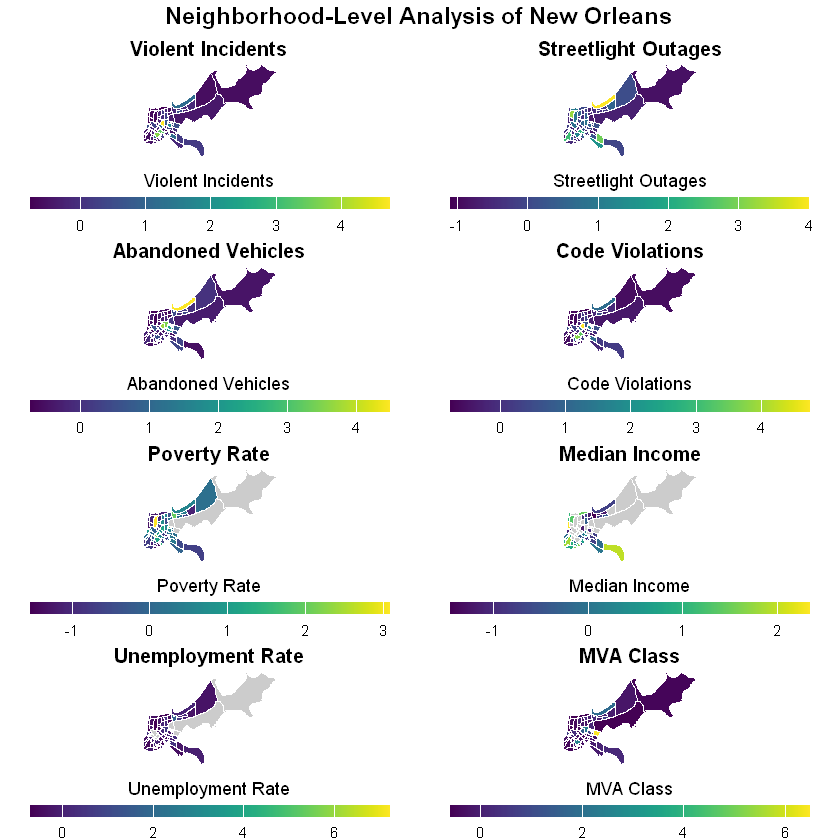

In [79]:
# Then create our maps with the correct column names
metrics_to_map <- c(
  "violent_count" = "Violent Incidents",
  "streetlight_outages" = "Streetlight Outages",
  "abandoned_vehicles" = "Abandoned Vehicles",
  "code_violations" = "Code Violations",
  "poverty_rate" = "Poverty Rate",
  "median_income" = "Median Income",
  "unemployment_rate" = "Unemployment Rate",
  "mva_class" = "MVA Class"
)

# Create function to generate maps
create_neighborhood_map <- function(data, variable, title) {
  ggplot(data) +
    geom_sf(aes(fill = .data[[variable]]), color = "white", size = 0.2) +
    scale_fill_viridis(
      name = title,
      na.value = "grey80",
      guide = guide_colorbar(
        barwidth = 15,
        barheight = 0.5,
        title.position = "top",
        title.hjust = 0.5
      )
    ) +
    theme_void() +
    theme(
      plot.title = element_text(size = 12, face = "bold", hjust = 0.5),
      legend.position = "bottom"
    ) +
    labs(title = title)
}

# Create list of maps
map_list <- lapply(
  names(metrics_to_map),
  function(metric) {
    create_neighborhood_map(
      neighborhood_final,
      metric,
      metrics_to_map[metric]
    )
  }
)

# Arrange maps in a grid
grid.arrange(
  grobs = map_list,
  ncol = 2,
  top = textGrob(
    "Neighborhood-Level Analysis of New Orleans",
    gp = gpar(fontsize = 14, fontface = "bold")
  )
)

**Assess Moran's *I* by risk factor**

In [84]:
create_neighborhood_hotspots <- function(data, variable_name) {
  # Extract base variable name (remove _mean suffix)
  base_name <- str_replace(variable_name, "_mean$", "")
  
  # Prepare data
  analysis_data <- data %>%
    select(gnocdc_lab, !!sym(variable_name), geometry) %>%
    na.omit()  # Remove NA values for valid spatial analysis
  
  # Find contiguous neighbors
  nb <- poly2nb(as_Spatial(analysis_data), queen=TRUE)
  
  # Generate spatial weights
  weights <- nb2listw(nb, style = 'W', zero.policy = TRUE)
  
  # Calculate Local Moran's I
  morans <- localmoran(analysis_data[[variable_name]], weights) %>%
    as.data.frame()
  
  # Add to spatial data
  analysis_data$sig_hotspot <- ifelse(morans[,5] <= 0.05, 1, 0)
  
  # Create the map
  hotspot_map <- ggplot() +
    geom_sf(data = analysis_data, 
            aes(fill = factor(sig_hotspot)),
            color = "white", 
            size = 0.2) +
    scale_fill_manual(
      name = "Significant\nHotspot",
      values = c("0" = "grey80", "1" = "#4495a2"),
      labels = c("No", "Yes")
    ) +
    labs(
      title = paste(str_to_title(str_replace_all(base_name, "_", " ")), 
                   "- Significant Hotspots"),
      subtitle = "By Neighborhood"
    ) +
    theme_void() +
    theme(
      plot.title = element_text(size = 12, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 10, hjust = 0.5),
      legend.position = "bottom"
    )
  
  return(list(
    data = analysis_data,
    map = hotspot_map,
    morans = morans
  ))
}

Warning message in poly2nb(as_Spatial(analysis_data), queen = TRUE):
"neighbour object has 2 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument."


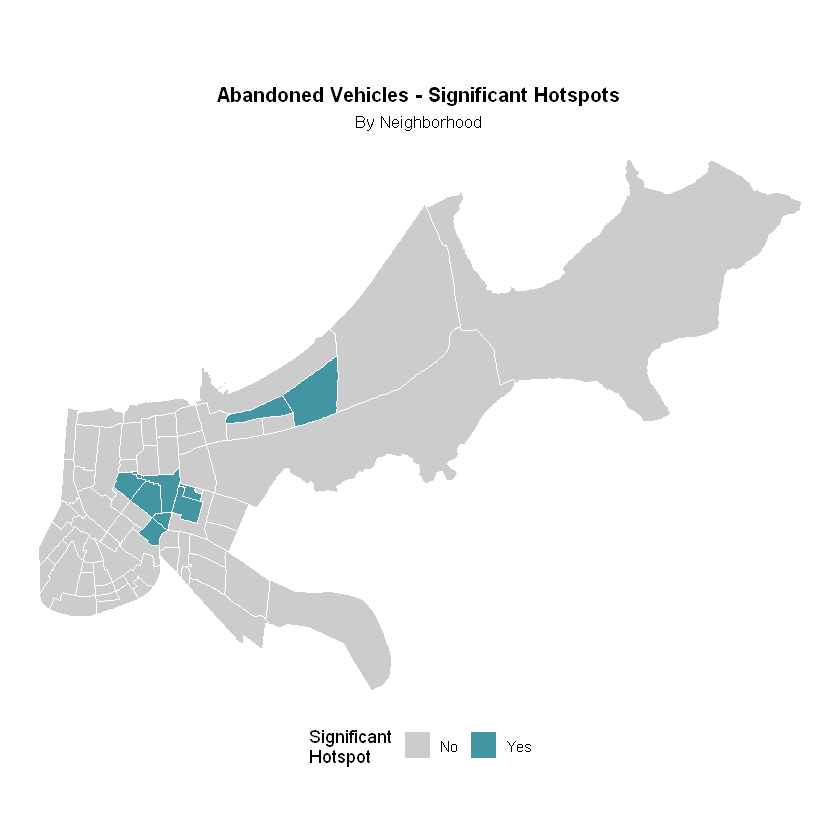

In [85]:
# Example usage for different variables:
# Variables available for analysis:
# - violent_count_mean
# - streetlight_outages_mean
# - abandoned_vehicles_mean
# - code_violations_mean
# - lot_abatements_mean
# - median_income_mean
# - poverty_rate_mean
# - unemployment_rate_mean
# - vacancy_rate_mean
# - renter_rate_mean

# Example for violent counts:
violent_hotspots <- create_neighborhood_hotspots(neighborhood_summary, "abandoned_vehicles_mean")
print(violent_hotspots$map)

 # Save the map
ggsave('./data/violent-neighborhood-hotspots.png',
       plot = violent_hotspots$map,
       width = 8,
       height = 6,
       dpi = 300)

# To create maps for all available variables:
variables <- c("violent_count_mean", "streetlight_outages_mean", 
              "abandoned_vehicles_mean", "code_violations_mean",
              "lot_abatements_mean", "median_income_mean",
              "poverty_rate_mean", "unemployment_rate_mean",
              "vacancy_rate_mean", "renter_rate_mean")

maps <- lapply(variables, function(var) {
   result <- create_neighborhood_hotspots(neighborhood_summary, var)
   ggsave(
       paste0('./data/hotspots-', gsub("_mean$", "", var), '.png'),
       plot = result$map,
       width = 8,
       height = 6,
       dpi = 300
      )
    return(result)
})

**Assess Moran's *I* by call type category**

In [94]:
# First, aggregate CFS data by neighborhood and call type
create_call_type_summary <- function(cfs_data, neighborhoods) {
  # Ensure neighborhoods is a valid sf object
  neighborhoods <- st_make_valid(neighborhoods)
  
  call_summary <- cfs_data %>%
    st_join(neighborhoods) %>%
    group_by(gnocdc_lab, predicted_category) %>%
    summarize(count = n(), .groups = "drop") %>%
    ungroup() %>%
    st_drop_geometry() %>%
    # Convert to wide format
    pivot_wider(
      names_from = predicted_category,
      values_from = count,
      values_fill = 0
    ) %>%
    # Join back with neighborhoods to get geometry
    left_join(neighborhoods, by = "gnocdc_lab") %>%
    # Convert back to sf and ensure validity
    st_as_sf() %>%
    st_make_valid()
    
  return(call_summary)
}

create_calltype_hotspots <- function(data, call_type) {
  # Prepare data and ensure spatial validity
  analysis_data <- data %>%
    select(gnocdc_lab, !!sym(call_type), geometry) %>%
    st_as_sf() %>%
    st_make_valid() %>%
    # Remove any empty geometries
    filter(!st_is_empty(.))
  
  # Find contiguous neighbors
  nb <- poly2nb(as_Spatial(analysis_data), queen=TRUE)
  
  # Generate spatial weights
  weights <- nb2listw(nb, style = 'W', zero.policy = TRUE)
  
  # Get the count vector
  count_vector <- pull(analysis_data, !!sym(call_type))
  
  # Calculate Local Moran's I
  morans <- localmoran(count_vector, weights) %>%
    as.data.frame()
  
  # Add to spatial data
  analysis_data$sig_hotspot <- ifelse(morans[,5] <= 0.05, 1, 0)
  
  # Create the map
  hotspot_map <- ggplot() +
    geom_sf(data = analysis_data, 
            aes(fill = factor(sig_hotspot)),
            color = "white", 
            size = 0.2) +
    scale_fill_manual(
      name = "Significant\nHotspot",
      values = c("0" = "grey80", "1" = "#7ca655"),
      labels = c("No", "Yes")
    ) +
    labs(
      title = paste(call_type, "Calls - Significant Hotspots"),
      subtitle = "By Neighborhood"
    ) +
    theme_void() +
    theme(
      plot.title = element_text(size = 12, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 10, hjust = 0.5),
      legend.position = "bottom"
    )
  
  return(list(
    data = analysis_data,
    map = hotspot_map,
    morans = morans
  ))
}

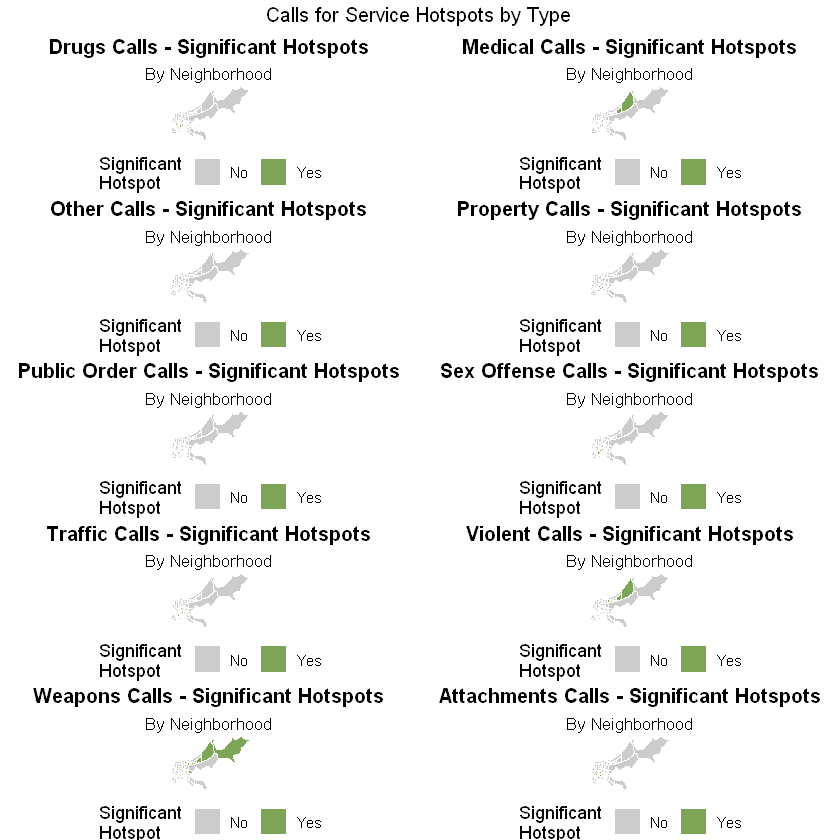

In [95]:
# Define the actual call types we want to analyze
call_types <- c("Drugs", "Medical", "Other", "Property", "Public Order", 
                "Sex Offense", "Traffic", "Violent", "Weapons", "Attachments")

# Create maps for all call types
call_maps <- lapply(call_types, function(type) {
  tryCatch({
    result <- create_calltype_hotspots(call_summary, type)
    ggsave(
      paste0('./data/hotspots-calltype-', tolower(gsub(" ", "-", type)), '.png'),
      plot = result$map,
      width = 8,
      height = 6,
      dpi = 300
    )
    return(result)
  }, error = function(e) {
    message(paste("Error processing", type, ":", e$message))
    return(NULL)
  })
})

# Create a grid of all maps
map_grid <- do.call(gridExtra::grid.arrange, 
                   c(lapply(call_maps[!sapply(call_maps, is.null)], 
                           function(x) x$map), 
                     ncol = 2,
                     top = "Calls for Service Hotspots by Type"))

# Save the grid
ggsave('./data/hotspots-all-calltypes.png',
       plot = map_grid,
       width = 16,
       height = 24,
       dpi = 300)

# **Step 13 - Understand relationship between features and call types**

In [115]:
# 1. First, create separate spatial files for each call type
call_types <- cfs_final %>%
  group_by(predicted_category) %>%
  group_split()

# Create a list to store neighborhood-level counts for each call type
neighborhood_calls <- lapply(call_types, function(calls) {
  st_join(calls, neighborhoods) %>%
    group_by(gnocdc_lab) %>%
    summarize(count = n()) %>%
    st_drop_geometry()
})

# Name the list elements by call type
names(neighborhood_calls) <- unique(cfs_final$predicted_category)

In [116]:
# 2. Create the base dataset with risk factors and census data
neighborhood_factors <- neighborhood_final %>%
  st_drop_geometry() %>%
  select(gnocdc_lab, 
         streetlight_outages, abandoned_vehicles, code_violations, lot_abatements,
         median_income, poverty_rate, unemployment_rate, vacancy_rate, renter_rate)

# 3. Join all call types to factors
correlation_data <- neighborhood_factors
for(type in names(neighborhood_calls)) {
  correlation_data <- correlation_data %>%
    left_join(
      neighborhood_calls[[type]] %>%
        rename(!!type := count),
      by = "gnocdc_lab"
    )
}

In [117]:
# 4. Calculate correlations
# Get risk/census factors and call type columns separately
factor_cols <- names(neighborhood_factors)[-1]  # exclude gnocdc_lab
call_cols <- names(neighborhood_calls)

# Create correlation matrix
cors <- matrix(
  nrow = length(factor_cols),
  ncol = length(call_cols)
)
rownames(cors) <- factor_cols
colnames(cors) <- call_cols

# Fill correlation matrix
for(i in seq_along(factor_cols)) {
  for(j in seq_along(call_cols)) {
    cors[i,j] <- cor(
      correlation_data[[factor_cols[i]]], 
      correlation_data[[call_cols[j]]], 
      use = "pairwise.complete.obs"
    )
  }
}

In [118]:
# 5. Visualize correlations
correlation_long <- as.data.frame(cors) %>%
  rownames_to_column("Factor") %>%
  gather(key = "Call_Type", value = "Correlation", -Factor)

correlation_heatmap <- ggplot(correlation_long, 
  aes(x = Call_Type, y = Factor, fill = Correlation)) +
  geom_tile() +
  scale_fill_viridis(limits = c(-1, 1)) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(angle = 0, hjust = 1)
  ) +
  labs(
    title = "Correlation between Risk Factors and Call Types",
    x = "Call Type",
    y = "Risk/Census Factor"
  )

In [155]:
# Function to calculate correlation statistics
get_cor_stats <- function(x, y) {
  if(all(is.na(x)) || all(is.na(y))) {
    return(list(
      correlation = NA,
      p_value = NA
    ))
  }
  
  test <- cor.test(x, y, use = "pairwise.complete.obs")
  
  return(list(
    correlation = test$estimate,
    p_value = test$p.value
  ))
}

# Create empty data frame to store results
results <- data.frame()

# Calculate correlations for each factor-call type combination
for(factor in names(neighborhood_factors)[-1]) {  # skip gnocdc_lab
  for(call_type in names(neighborhood_calls)) {
    stats <- get_cor_stats(
      correlation_data[[factor]], 
      correlation_data[[call_type]]
    )
    
    results <- rbind(results, data.frame(
      Factor = factor,
      Call_Type = call_type,
      Correlation = stats$correlation,
      p_value = stats$p_value
    ))
  }
}

# Process results
strong_correlations <- results %>%
  group_by(Call_Type) %>%
  arrange(desc(abs(Correlation))) %>%
  slice_head(n = 20) %>%
  mutate(
    Correlation = round(Correlation, 3),
    p_value = round(p_value, 4),
    significance = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01 ~ "**",
      p_value < 0.05 ~ "*",
      TRUE ~ "ns"
    )
  )

# Display results
print(strong_correlations %>%
  arrange(Call_Type, desc(abs(Correlation))) %>%
  kable(
    col.names = c("Risk/Census Factor", "Call Type", "Correlation", 
                 "p-value", "Significance"),
    caption = "Top 3 Strongest Correlations for Each Call Type"
  ))



Table: Top 3 Strongest Correlations for Each Call Type

|Risk/Census Factor  |Call Type    | Correlation| p-value|Significance |
|:-------------------|:------------|-----------:|-------:|:------------|
|abandoned_vehicles  |Attachments  |       0.717|  0.0000|***          |
|code_violations     |Attachments  |       0.592|  0.0000|***          |
|streetlight_outages |Attachments  |       0.437|  0.0001|***          |
|median_income       |Attachments  |      -0.408|  0.0049|**           |
|poverty_rate        |Attachments  |       0.284|  0.0189|*            |
|lot_abatements      |Attachments  |       0.229|  0.0531|ns           |
|unemployment_rate   |Attachments  |       0.060|  0.6378|ns           |
|renter_rate         |Attachments  |       0.048|  0.7230|ns           |
|vacancy_rate        |Attachments  |      -0.008|  0.9520|ns           |
|code_violations     |Drugs        |       0.744|  0.0000|***          |
|abandoned_vehicles  |Drugs        |       0.675|  0.0000|***     

In [156]:
# Display results
print(strong_correlations %>% 
  arrange(desc(abs(Correlation))) %>%
  filter(significance != 'ns') %>%
  kable(
    col.names = c("Risk/Census Factor", "Call Type", "Correlation", 
                 "p-value", "Significance"),
    caption = "Strongest correlations between features and outcomes"
  ))



Table: Strongest correlations between features and outcomes

|Risk/Census Factor  |Call Type    | Correlation| p-value|Significance |
|:-------------------|:------------|-----------:|-------:|:------------|
|code_violations     |Sex Offense  |       0.804|  0.0000|***          |
|code_violations     |Violent      |       0.795|  0.0000|***          |
|code_violations     |Medical      |       0.778|  0.0000|***          |
|code_violations     |Property     |       0.753|  0.0000|***          |
|code_violations     |Drugs        |       0.744|  0.0000|***          |
|abandoned_vehicles  |Attachments  |       0.717|  0.0000|***          |
|code_violations     |Public Order |       0.717|  0.0000|***          |
|code_violations     |Other        |       0.698|  0.0000|***          |
|abandoned_vehicles  |Drugs        |       0.675|  0.0000|***          |
|code_violations     |Traffic      |       0.660|  0.0000|***          |
|streetlight_outages |Property     |       0.622|  0.0000|***